# Capstone 2: Forecasting Pharmacy Medication Sales
## R06—antihistamines for systemic use

**Overview**: This capstone project explores seasonal decomposition and neural network models to find the best model to forecast pharmacy medication sales.

In this application, I will compare the performance of regression models, namely seasonal decomposition, ARMA, SARIMAX, Dense neural network, simple RNN, one-layer LSTM, and stacked LSTM. I will utilize a dataset from Kaggle consisting of weekly pharmacy sale data collected over six years, from 2014 to 2019, for eight drug categories. In this Jupyter Notebook, I will explore one category: R06—antihistamines for systemic use.

### Getting Started

I will utilize a dataset from [Kaggle](https://www.kaggle.com/datasets/milanzdravkovic/pharma-sales-data) consisting of weekly pharmacy sale data collected over six years, from 2014 to 2019, for eight drug categories. In this Jupyter Notebook, I will explore one category: R06—antihistamines for systemic use.  This dataset contains daily, weekly, monthly and hourly sale aggregates.  For this project, I will perform my analysis using the weekly sales dataset.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.filters.filtertools import convolution_filter
import statsmodels.graphics.tsaplots as tsplots
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import _extrapolate_trend
from datetime import timedelta
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import tensorflow
from time import process_time
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Flatten, MaxPooling1D, Conv1D, GlobalAveragePooling1D
from keras import metrics
from array import array
import plotly.graph_objects as go
from matplotlib.animation import FuncAnimation
import warnings
warnings.filterwarnings("ignore")

2024-03-26 18:37:56.654117: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-26 18:37:57.216010: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Understanding the Data

The pharmacy daily sales contains 2106 data points.  These datapoints were averaged by week and compiled into a weekly sales dataset.

#### Read in the Data

In [2]:
sales_daily = pd.read_csv('salesdaily.csv')
sales_daily

datum  M01AB   M01AE  N02BA  N02BE  N05B  N05C   R03   R06  Year  \
0      1/2/2014   0.00   3.670   3.40  32.40   7.0   0.0   0.0  2.00  2014   
1      1/3/2014   8.00   4.000   4.40  50.60  16.0   0.0  20.0  4.00  2014   
2      1/4/2014   2.00   1.000   6.50  61.85  10.0   0.0   9.0  1.00  2014   
3      1/5/2014   4.00   3.000   7.00  41.10   8.0   0.0   3.0  0.00  2014   
4      1/6/2014   5.00   1.000   4.50  21.70  16.0   2.0   6.0  2.00  2014   
...         ...    ...     ...    ...    ...   ...   ...   ...   ...   ...   
2101  10/4/2019   7.34   5.683   2.25  22.45  13.0   0.0   1.0  1.00  2019   
2102  10/5/2019   3.84   5.010   6.00  25.40   7.0   0.0   0.0  0.33  2019   
2103  10/6/2019   4.00  11.690   2.00  34.60   6.0   0.0   5.0  4.20  2019   
2104  10/7/2019   7.34   4.507   3.00  50.80   6.0   0.0  10.0  1.00  2019   
2105  10/8/2019   0.33   1.730   0.50  44.30  20.0   2.0   2.0  0.00  2019   

      Month  Hour Weekday Name  
0         1   248     Thursday  
1         1   276       Friday  
2         1   276     Saturday  
3         1   276       Sunday  
4         1   276       Monday  
...     ...   ...          ...  
2101     10   276       Friday  
2102     10   276     Saturday  
2103     10   276       Sunday  
2104     10   276       Monday  
2105     10   190      Tuesday  

[2106 rows x 13 columns]

In [3]:
sales_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2106 entries, 0 to 2105
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   datum         2106 non-null   object 
 1   M01AB         2106 non-null   float64
 2   M01AE         2106 non-null   float64
 3   N02BA         2106 non-null   float64
 4   N02BE         2106 non-null   float64
 5   N05B          2106 non-null   float64
 6   N05C          2106 non-null   float64
 7   R03           2106 non-null   float64
 8   R06           2106 non-null   float64
 9   Year          2106 non-null   int64  
 10  Month         2106 non-null   int64  
 11  Hour          2106 non-null   int64  
 12  Weekday Name  2106 non-null   object 
dtypes: float64(8), int64(3), object(2)
memory usage: 214.0+ KB


In [4]:
sales_weekly = pd.read_csv('salesweekly.csv')
sales_weekly

datum  M01AB   M01AE  N02BA    N02BE  N05B  N05C        R03    R06
0      1/5/2014  14.00  11.670  21.30  185.950  41.0   0.0  32.000000   7.00
1     1/12/2014  29.33  12.680  37.90  190.700  88.0   5.0  21.000000   7.20
2     1/19/2014  30.67  26.340  45.90  218.400  80.0   8.0  29.000000  12.00
3     1/26/2014  34.00  32.370  31.50  179.600  80.0   8.0  23.000000  10.00
4      2/2/2014  31.02  23.350  20.70  159.880  84.0  12.0  29.000000  12.00
..          ...    ...     ...    ...      ...   ...   ...        ...    ...
297   9/15/2019  35.51  30.977  19.65  178.375  67.2   5.0  30.000000  30.50
298   9/22/2019  46.84  25.396  24.40  248.250  31.2   3.0  26.000000  21.00
299   9/29/2019  34.01  22.498  26.60  336.700  61.2   1.0  40.416667  23.10
300   10/6/2019  38.70  32.502  19.25  249.450  69.0   5.0  30.000000  12.13
301  10/13/2019   7.67   6.237   3.50   95.100  26.0   2.0  12.000000   1.00

[302 rows x 9 columns]

#### Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Initial dataset consisted of 600000 transactional data collected in 6 years (period 2014-2019), indicating date and time of sale, pharmaceutical drug brand name and sold quantity. As a result of the interviews with pharmacists, decision was made that the subject of analyses and forecasting will be actual drug categories, instead of the individual drugs. Thus, selected group of drugs (57 drugs) is classified to 8 Anatomical Therapeutic Chemical (ATC) Classification System categories:

Input variables:
# Medication categories:
M01AB - Anti-inflammatory and antirheumatic products, non-steroids, Acetic acid derivatives and related substances
M01AE - Anti-inflammatory and antirheumatic products, non-steroids, Propionic acid derivatives
N02BA - Other analgesics and antipyretics, Salicylic acid and derivatives
N02BE/B - Other analgesics and antipyretics, Pyrazolones and Anilides
N05B - Psycholeptics drugs, Anxiolytic drugs
N05C - Psycholeptics drugs, Hypnotics and sedatives drugs
R03 - Drugs for obstructive airway diseases
R06 - Antihistamines for systemic use

Output:
Sales forecast for 3 of the medication categories:
M01AB - Anti-inflammatory and antirheumatic products, non-steroids, Acetic acid derivatives and related substances
R03 - Drugs for obstructive airway diseases
R06 - Antihistamines for systemic use
```



#### R06 - Antihistamines for systemic use
For this project, I will focus on medication category R06 - Antihistamines for systemic use.

In [5]:
med_name = 'R06'
med_description = 'Antihistamines for systemic use'

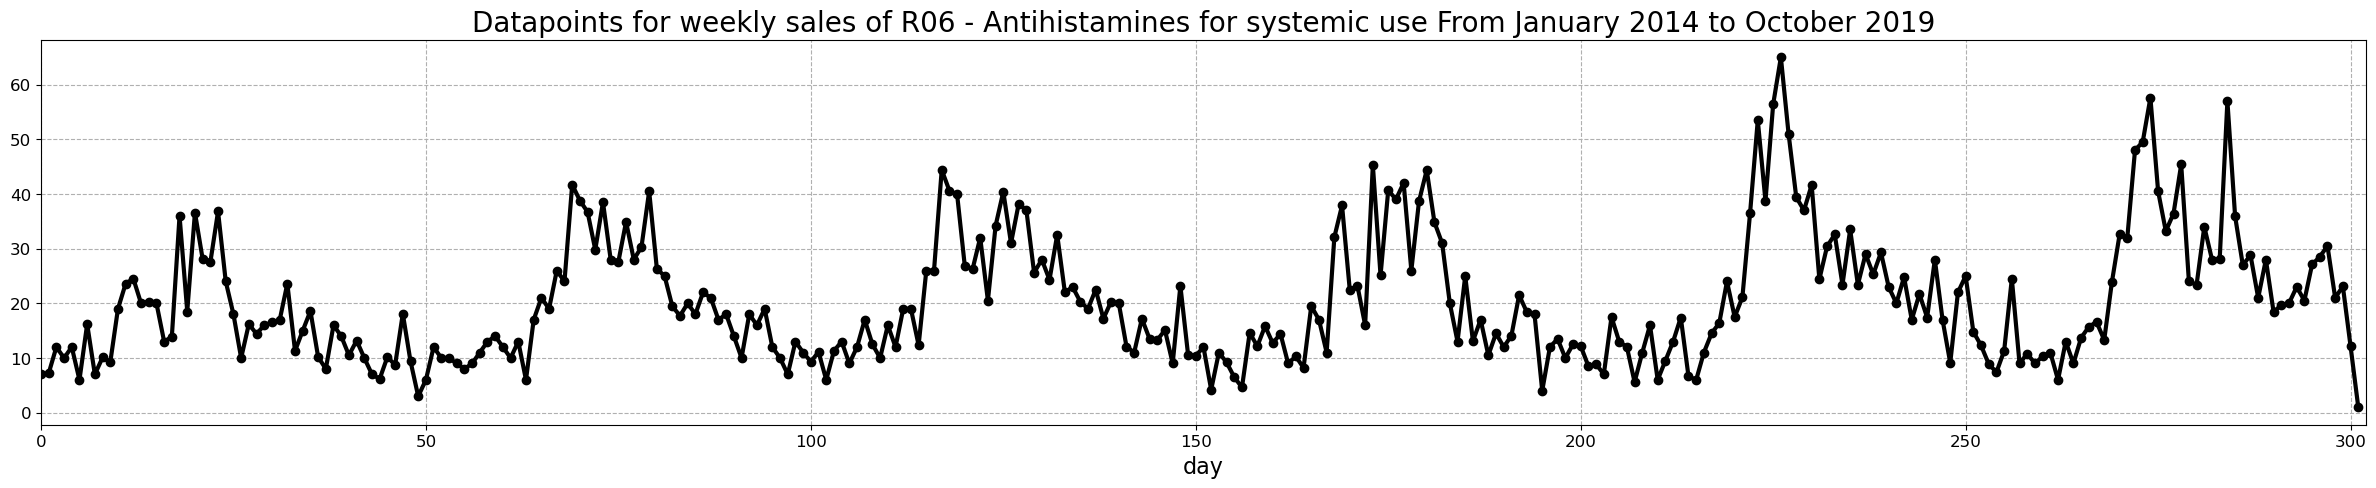

In [6]:
plt.figure(figsize=(30,5))
plt.plot(sales_weekly['R06'],'ko-',linewidth=3)
plt.grid(linestyle='--')
plt.xlim(0,302)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('day',fontsize=16)
plt.title("Datapoints for weekly sales of " + med_name + " - " + med_description +  " From January 2014 to October 2019", fontsize=20)
plt.savefig(med_name + "-focus.png")

#### Business Objective

My business objective is to find the best model to predict the sales of:
```
R06 - Antihistamines for systemic use
```

### Engineering Features

To achieve my business objective, I will build a basic model to get started. As the basic model, I will utilize the statsmodel library to generate seasonal decomposition model.

Build a dataframe using timestamp as the index

In [7]:
df_r06_weekly = sales_weekly[['datum','R06']].set_index(pd.to_datetime(sales_weekly['datum'])) \
    .drop(columns=['datum'])
df_r06_weekly.rename(columns={"R06": "values"}, inplace=True)
df_r06_weekly

values
datum             
2014-01-05    7.00
2014-01-12    7.20
2014-01-19   12.00
2014-01-26   10.00
2014-02-02   12.00
...            ...
2019-09-15   30.50
2019-09-22   21.00
2019-09-29   23.10
2019-10-06   12.13
2019-10-13    1.00

[302 rows x 1 columns]

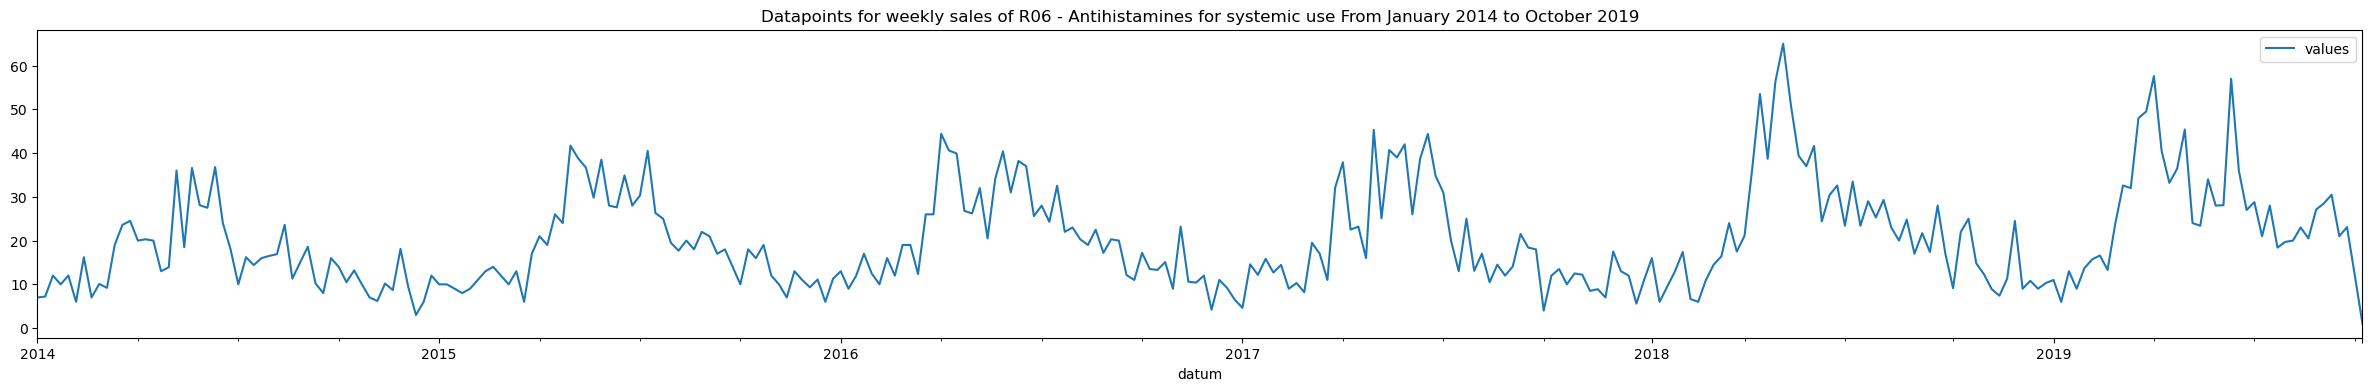

In [8]:
df_r06_weekly.plot(figsize=(30,4))
plt.title("Datapoints for weekly sales of " + med_name + " - " + med_description +  " From January 2014 to October 2019")
plt.savefig(med_name + "-dataframe.png")

In [9]:
df_r06_weekly.index.year.value_counts()

datum
2017    53
2014    52
2015    52
2016    52
2018    52
2019    41
Name: count, dtype: int64

In [10]:
# period is about 52 weeks
period_r06 = 52
period = period_r06
period

52

##### Train/Test Split
Split data into a train and test set.

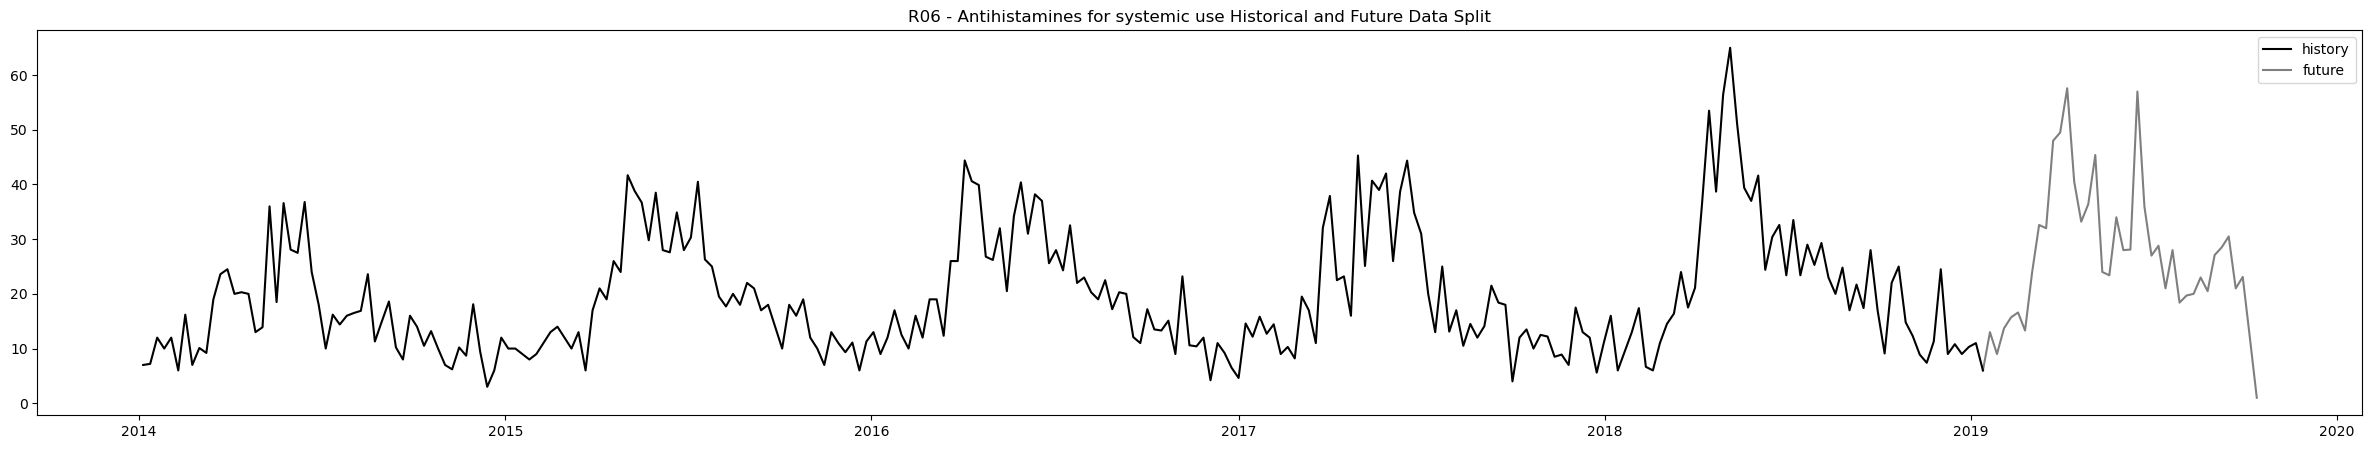

In [11]:
y_r06_hist = df_r06_weekly.loc[:'2019-01-14','values']
y_r06_future = df_r06_weekly.loc['2019-01-13':,'values']

plt.figure(figsize=(30,5))
plt.plot(y_r06_hist,'k', label='history')
plt.plot(y_r06_future,'k',alpha=0.5, label='future')
plt.legend()
plt.title(med_name + " - " + med_description + " Historical and Future Data Split")
plt.savefig(med_name + "-train-test-split.png")

#### Build Performance Dataframe
Generate a data frame to track each model's performance.

In [12]:
res_dict = {'model': ['Baseline-Statsmodel Decomposition', 'Manual Decomposition', 'ARMA', 'SARIMAX','Dense','RNN','LSTM', 'Conv1D','LSTM2'],
           'train time': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
           'train MAE': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
           'test MAE': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
           'train RMSE': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
           'test RMSE': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}
results_df = pd.DataFrame(res_dict).set_index('model')

results_df

train time  train MAE  test MAE  \
model                                                                
Baseline-Statsmodel Decomposition         0.0        0.0       0.0   
Manual Decomposition                      0.0        0.0       0.0   
ARMA                                      0.0        0.0       0.0   
SARIMAX                                   0.0        0.0       0.0   
Dense                                     0.0        0.0       0.0   
RNN                                       0.0        0.0       0.0   
LSTM                                      0.0        0.0       0.0   
Conv1D                                    0.0        0.0       0.0   
LSTM2                                     0.0        0.0       0.0   

                                   train RMSE  test RMSE  
model                                                     
Baseline-Statsmodel Decomposition         0.0        0.0  
Manual Decomposition                      0.0        0.0  
ARMA                                      0.0        0.0  
SARIMAX                                   0.0        0.0  
Dense                                     0.0        0.0  
RNN                                       0.0        0.0  
LSTM                                      0.0        0.0  
Conv1D                                    0.0        0.0  
LSTM2                                     0.0        0.0

### Build a baseline model

Before we build our first model, we want to establish a baseline.  We will use the statsmodel seasonal decomposition library as our baseline.

In [13]:
def decompose(df, column_name, modelname, pltname):
    result = seasonal_decompose(df[column_name], model=modelname, extrapolate_trend = 'freq', period=period_r06)
    return result

In [14]:
def decom_plot(res, plotname):
    plt.figure(figsize=(30,5))
    plt.title(plotname + ' Seasonal Decomposition Model')
    plt.plot(res.seasonal,'k',label='seasonal')
    plt.plot(res.trend,'r',linewidth=1,label='trend')
    plt.plot(res.resid,'g',alpha=0.5,label='residual')
    plt.plot(res.observed, 'b',alpha=0.5,label='actual_value')
    plt.legend()
    plt.savefig(plotname + "-seasonal-decomp-model.png")

In [15]:
def reconstruct(decom_res):
    df_recon = pd.concat([decom_res.seasonal, decom_res.trend, decom_res.resid, decom_res.observed], axis = 1)
    df_recon.columns = ['seasonal', 'trend', 'residual', 'actual_values']
    
    return df_recon

In [16]:
tsa_start = process_time()
r06_decomposed = decompose(df_r06_weekly, "values", 'additive', med_name)
tsa_end = process_time()

tsa_fit_time = tsa_end - tsa_start
print(tsa_fit_time)

0.002082475000000361


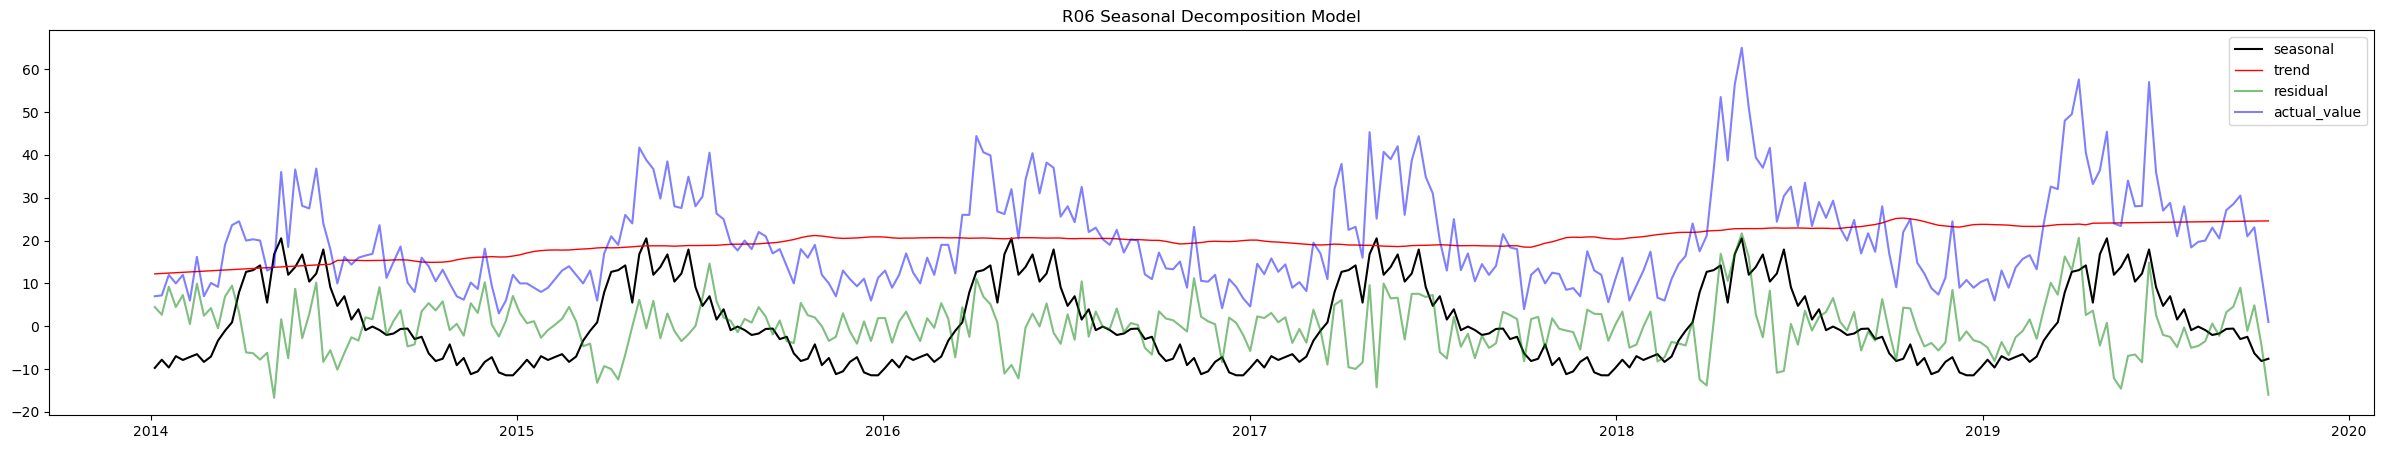

In [17]:
r06_recon_df = reconstruct(r06_decomposed)
decom_plot(r06_decomposed, med_name)

In [18]:
r06_recon_df

seasonal      trend   residual  actual_values
datum                                                    
2014-01-05 -9.727442  12.229754   4.497688           7.00
2014-01-12 -7.813518  12.319927   2.693591           7.20
2014-01-19 -9.628760  12.410100   9.218661          12.00
2014-01-26 -6.979152  12.500272   4.478880          10.00
2014-02-02 -7.870623  12.590445   7.280178          12.00
...              ...        ...        ...            ...
2019-09-15 -2.999367  24.500534   8.998833          30.50
2019-09-22 -2.454101  24.522209  -1.068108          21.00
2019-09-29 -6.325983  24.543884   4.882099          23.10
2019-10-06 -8.114980  24.565559  -4.320579          12.13
2019-10-13 -7.584971  24.587234 -16.002264           1.00

[302 rows x 4 columns]

##### Residual Size

In [19]:
tsa_residue_MAEm = np.abs(r06_recon_df['residual']).mean()
tsa_residue_RMSEm = np.sqrt( np.square(r06_recon_df['residual']).mean() )
tsa_residue_MAEm, tsa_residue_RMSEm

(4.681426284791636, 6.102016745560865)

##### Residual Stationarity

In [20]:
def plot_acf_colors(ax, markercolor="purple", linecolor="purple", facecolor="silver", barcolor="black", linewidth=1):
    """utility function to get some control over colors with  plot_acf()"""
    from statsmodels.graphics.tsaplots import plot_pacf
    from statsmodels.graphics.tsaplots import plot_acf
    from matplotlib.collections import PolyCollection, LineCollection
    for item in ax.collections:
        # change the color of the confidence interval 
        if type(item) == PolyCollection:
            item.set_facecolor(facecolor)
        # change the color of the vertical lines
        if type(item) == LineCollection:
            item.set_color(barcolor)
    # change the color of the markers
    [line.get_label() for line in ax.lines]
    for item in ax.lines:
        item.set_color(markercolor)
    # change the color of the horizontal lines
    ax.lines[0].set_color(linecolor)
    ax.lines[0].set_linewidth(linewidth)
    #ax.lines.remove(ax.lines[0])
    return ax

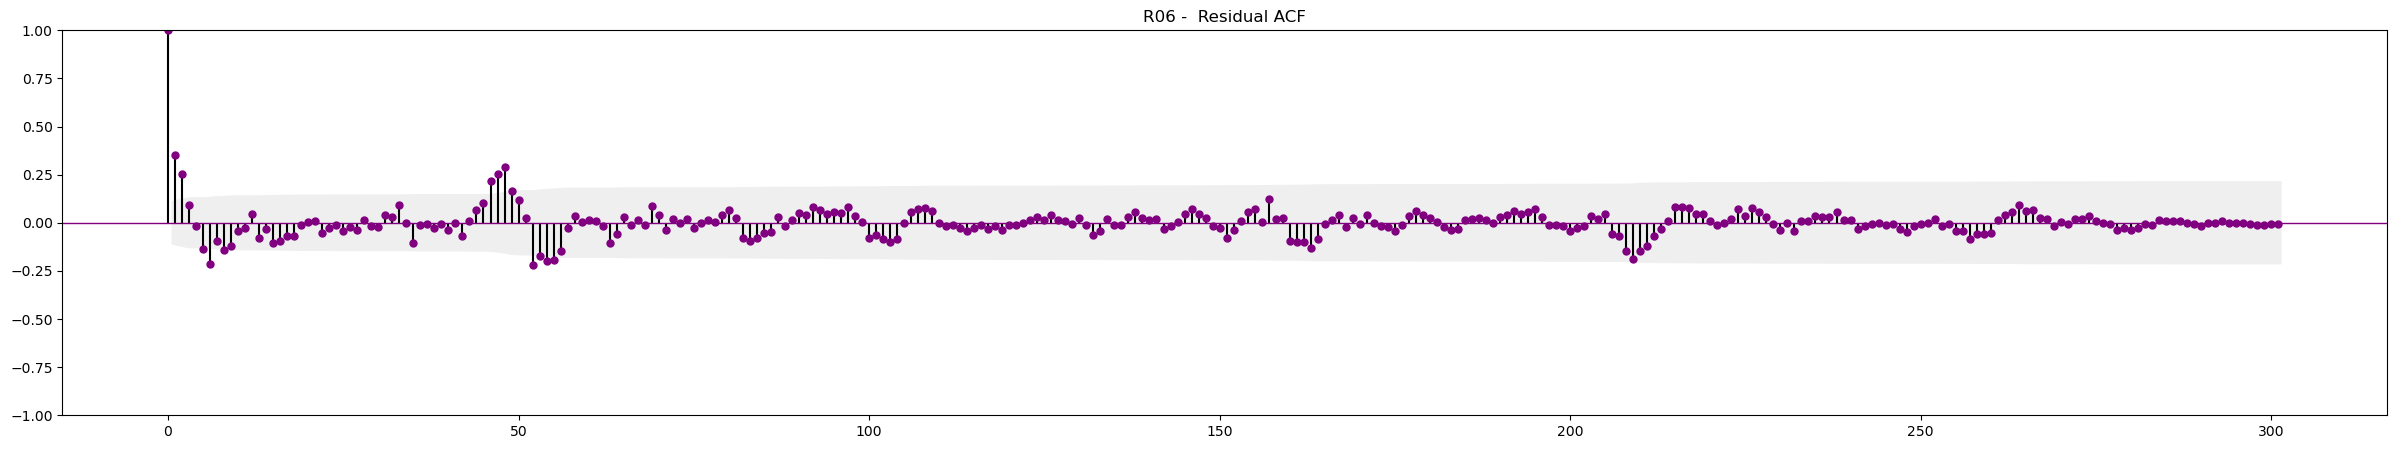

In [21]:
f, ax = plt.subplots(figsize=(30,5))
plot_acf(r06_recon_df['residual'], lags=301, ax=ax)
plt.title(med_name + " - " + " Residual ACF")
ax = plot_acf_colors(ax)
plt.savefig(med_name + "-acf.png")

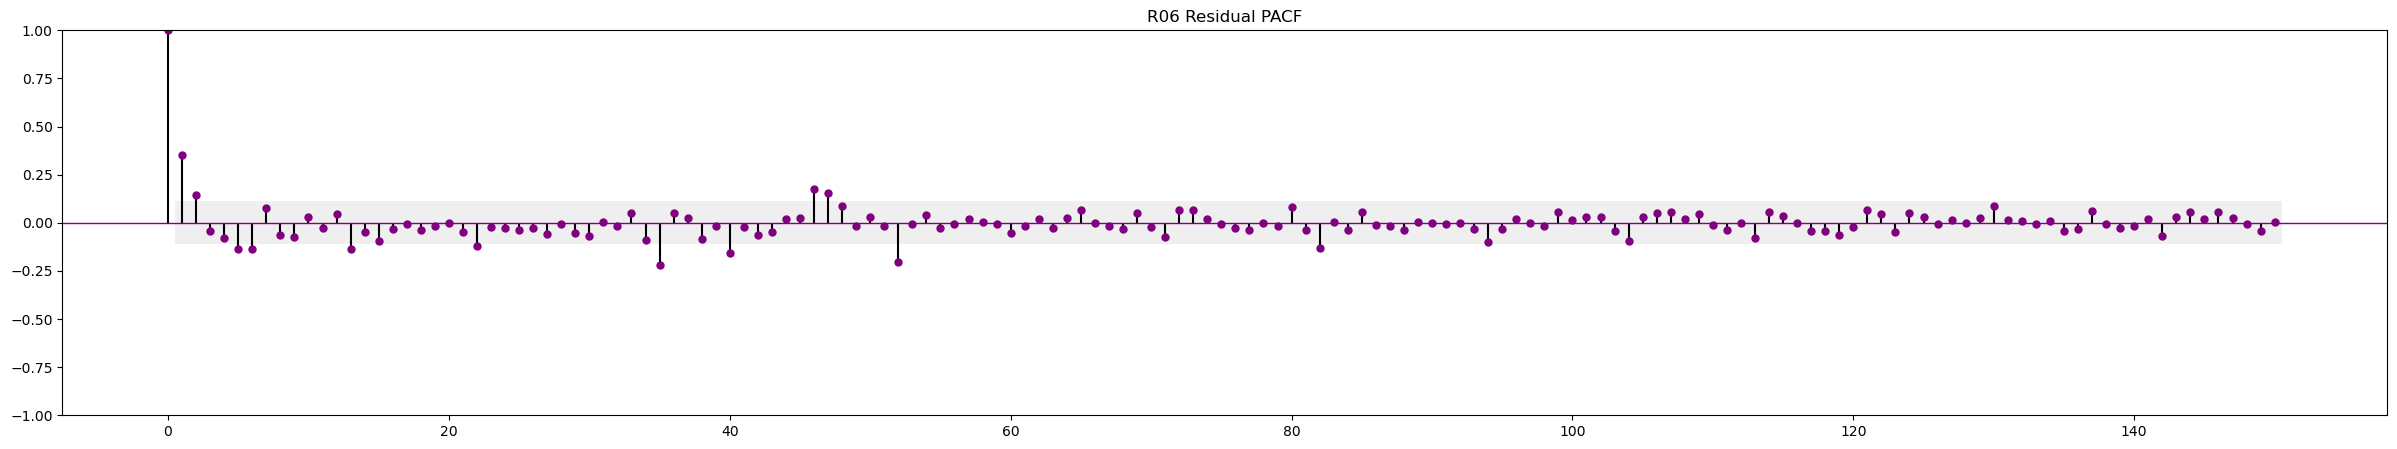

In [22]:
f, ax = plt.subplots(figsize=(30, 5))
plot_pacf(r06_recon_df['residual'], lags=150, ax=ax)
ax = plot_acf_colors(ax)
plt.title(med_name + " Residual PACF")
plt.savefig(med_name + "-pacf.png")

Residual ACF and PACF seem to be pretty stationary.

**AdFuller Stationarity test**
* The ADF statistic is a test statistic used to determine the stationarity of the time series. The larger the ADF statistic, the more likely the time series is stationary.
* The p-value indicates the probability of observing the given ADF statistic (or a more extreme value) if the null hypothesis (the time series is non-stationary) is true. If the p-value is less than a specified significance level (e.g., 0.05), we reject the null hypothesis and conclude that the time series is stationary.

In [23]:
stationary_test = adfuller(r06_recon_df['residual'])
print('ADF Statistic: %f' % stationary_test[0])
print('p-value: %f' % stationary_test[1])
stationary_test

ADF Statistic: -8.373727
p-value: 0.000000


(-8.373727310946922,
 2.6201042311827e-13,
 5,
 296,
 {'1%': -3.452636878592149,
  '5%': -2.8713543954331433,
  '10%': -2.5719993576515705},
 1796.3390777683212)

p-value is less than 0.05, therefore the residual model seems to be stationary.

#### Forecast

In [24]:
f = len(y_r06_future)
f_periods = int(1 + f/period)
tsa_yhat_trend = pd.Series(index=y_r06_future.index, data=r06_decomposed.trend[-1])
tsa_yhat_seasonal = pd.Series(index=y_r06_future.index, data=r06_decomposed.seasonal)

In [25]:
tsa_yhat_seasonal

datum
2019-01-13    -9.628760
2019-01-20    -6.979152
2019-01-27    -7.870623
2019-02-03    -7.172351
2019-02-10    -6.514986
2019-02-17    -8.319662
2019-02-24    -7.078922
2019-03-03    -3.366387
2019-03-10    -1.051031
2019-03-17     0.911889
2019-03-24     7.936123
2019-03-31    12.698498
2019-04-07    13.099607
2019-04-14    14.201498
2019-04-21     5.520781
2019-04-28    16.832267
2019-05-05    20.524684
2019-05-12    12.015017
2019-05-19    13.833876
2019-05-26    16.763215
2019-06-02    10.419606
2019-06-09    12.310484
2019-06-16    17.919535
2019-06-23     9.114676
2019-06-30     4.756878
2019-07-07     7.008554
2019-07-14     1.563467
2019-07-21     3.959662
2019-07-28    -0.910617
2019-08-04    -0.071762
2019-08-11    -0.886913
2019-08-18    -2.038442
2019-08-25    -1.695901
2019-09-01    -0.628199
2019-09-08    -0.543831
2019-09-15    -2.999367
2019-09-22    -2.454101
2019-09-29    -6.325983
2019-10-06    -8.114980
2019-10-13    -7.584971
Name: seasonal, dtype: float64

In [26]:
tsa_yhat = tsa_yhat_trend + tsa_yhat_seasonal

In [27]:
tsa_pred_error = y_r06_future - tsa_yhat

In [28]:
def season_trend(trend, seasonal):
    result = trend + seasonal

    return result

In [29]:
tsa_season_and_trend = r06_recon_df.apply(lambda row: season_trend(row['trend'], row['seasonal']), axis=1)

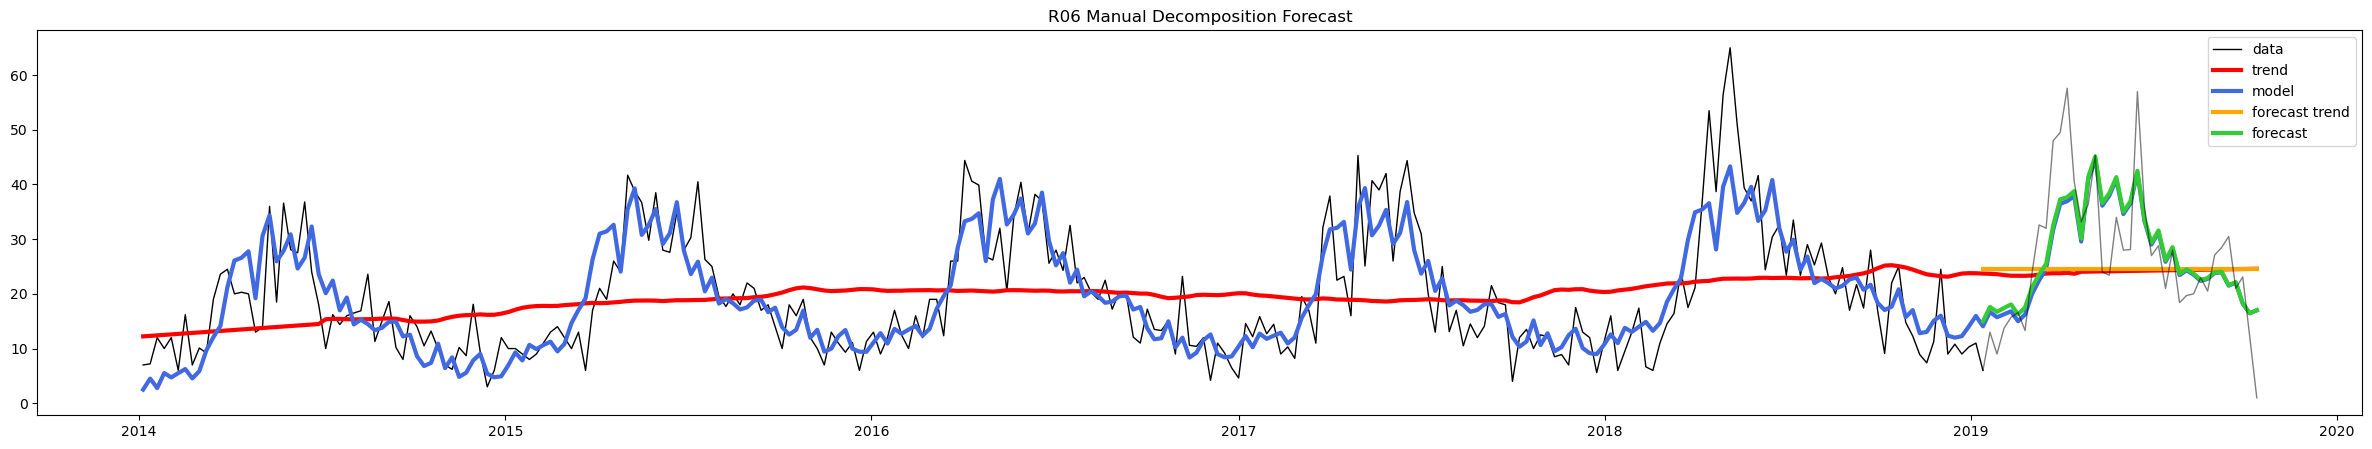

In [30]:
plt.figure(figsize=(30,5))
plt.plot(y_r06_hist,'k',label='data',linewidth=1)
plt.plot(r06_decomposed.trend,label='trend',color='red',linewidth=3)
plt.plot(tsa_season_and_trend,label='model',color='royalblue',linewidth=3)
plt.plot(tsa_yhat_trend,label='forecast trend',color='orange',linewidth=3)
plt.plot(tsa_yhat,label='forecast',color='limegreen',linewidth=3)
plt.plot(y_r06_future,'k',alpha=0.5,linewidth=1)
plt.legend();
plt.title(med_name + " Manual Decomposition Forecast")
plt.savefig(med_name + "-manual-decomp-forecast.png")

#### Prediction Error

In [31]:
tsa_pred_error = y_r06_future - tsa_yhat

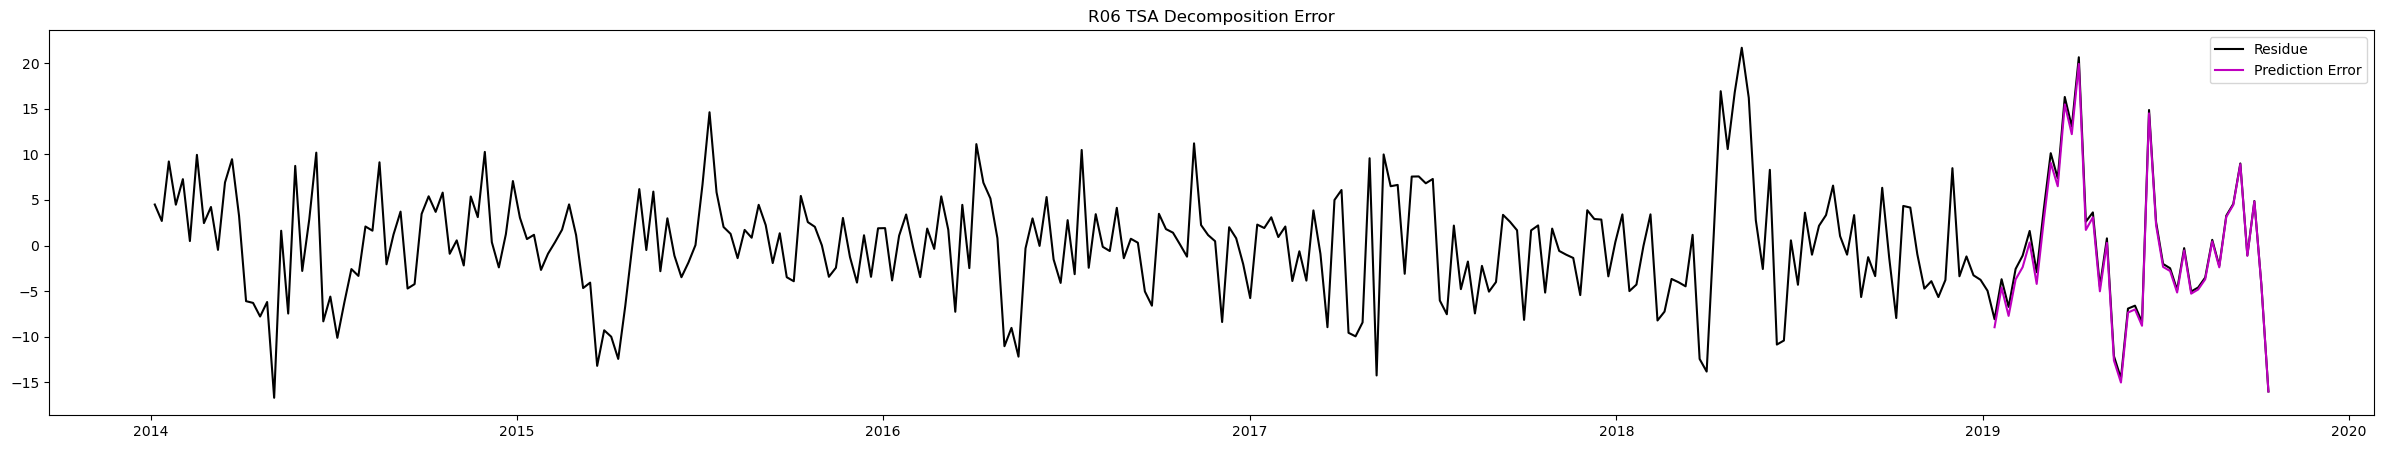

In [32]:
plt.figure(figsize=(30,5))
plt.plot(r06_recon_df['residual'],'k',label='Residue')
plt.plot(tsa_pred_error,'m',label='Prediction Error')
plt.legend();
plt.title(med_name + " TSA Decomposition Error")
plt.savefig(med_name + "-tsa-decomp-error.png")

In [33]:
tsa_decomp_pred_MAEp = np.abs(tsa_pred_error).mean()
tsa_decomp_pred_RMSEp = np.sqrt( np.square(tsa_pred_error).mean() )
tsa_decomp_pred_MAEp, tsa_decomp_pred_RMSEp

(6.141950068660833, 7.830218347371282)

### Simple Model - Manual Seasonal Decomposition

Use manual seasonal decomposition to build a basic model.  

In [34]:
manual_decomp_start = process_time()

#### Extract the Trend

In [35]:
period = 52

filt = np.ones(period+1)
filt[0] = 0.5
filt[-1] = 0.5
filt /= period

In [36]:
trend = convolution_filter(y_r06_hist, filt)
trend = _extrapolate_trend(trend, period + 1)

Text(0.5, 1.0, 'R06 Trend')

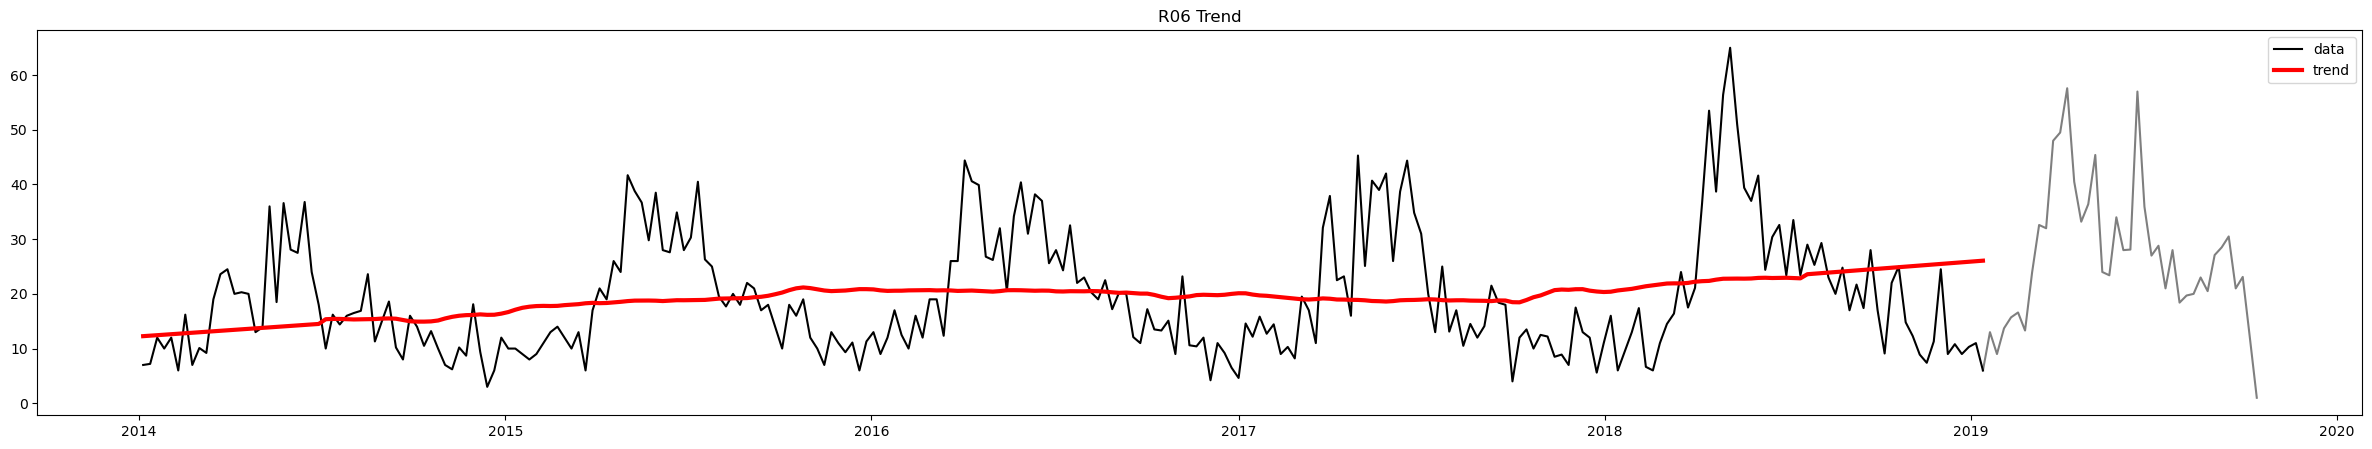

In [37]:
plt.figure(figsize=(30,5))
plt.plot(y_r06_hist,'k',label='data')
plt.plot(trend,'r',linewidth=3,label='trend')
plt.plot(y_r06_future,'k',alpha=0.5)
plt.legend()
plt.title(med_name + " Trend")
# plt.savefig(med_name + "-trend.png")

#### Detrended data

In [38]:
detrended = y_r06_hist - trend
detrended = detrended.to_numpy()

Text(0.5, 1.0, 'R06 Detrended Data')

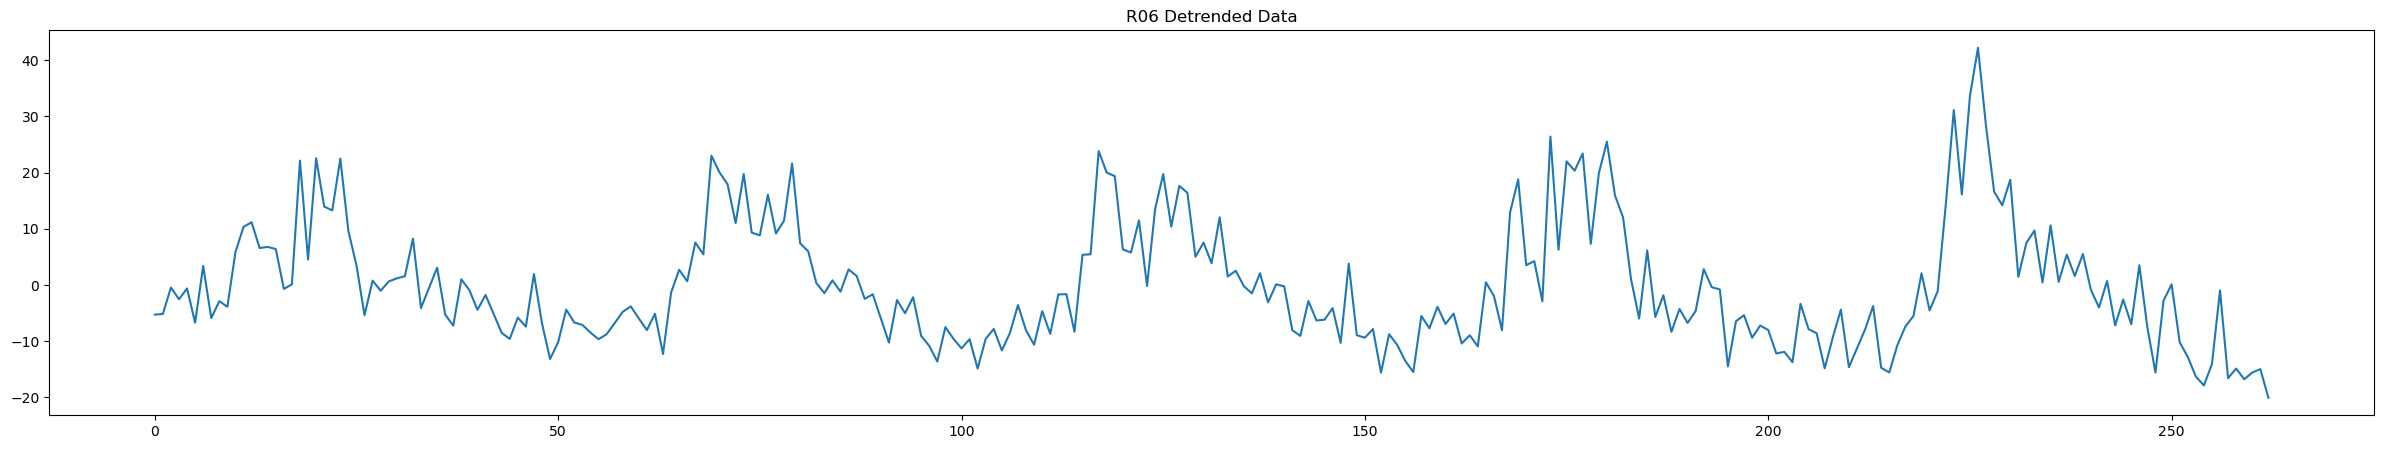

In [39]:
plt.figure(figsize=(30,5))
plt.plot(detrended)
plt.savefig("R06-detrended.png")
plt.title(med_name + " Detrended Data")
# plt.savefig(med_name + "-detrended.png")

#### Split the historical data into seasons

In [40]:
sales_weekly[['datum','R06']].query('R06 < 10')

datum    R06
0      1/5/2014  7.000
1     1/12/2014  7.200
5      2/9/2014  6.000
7     2/23/2014  7.000
9      3/9/2014  9.200
37    9/21/2014  8.000
43    11/2/2014  7.000
44    11/9/2014  6.200
46   11/23/2014  8.700
48    12/7/2014  9.400
49   12/14/2014  3.000
50   12/21/2014  6.000
54    1/18/2015  9.000
55    1/25/2015  8.000
56     2/1/2015  9.000
63    3/22/2015  6.000
97   11/15/2015  7.000
100   12/6/2015  9.330
102  12/20/2015  6.000
105   1/10/2016  9.000
147  10/30/2016  9.000
152   12/4/2016  4.200
154  12/18/2016  9.200
155  12/25/2016  6.500
156    1/1/2017  4.625
162   2/12/2017  9.000
164   2/26/2017  8.200
195   10/1/2017  4.000
201  11/12/2017  8.500
202  11/19/2017  8.900
203  11/26/2017  7.000
207  12/24/2017  5.600
210   1/14/2018  6.000
211   1/21/2018  9.500
214   2/11/2018  6.660
215   2/18/2018  6.000
248   10/7/2018  9.100
253  11/11/2018  8.900
254  11/18/2018  7.400
257   12/9/2018  9.000
259  12/23/2018  9.000
262   1/13/2019  6.000
264   1/27/2019  9.000
301  10/13/2019  1.000

In [41]:
lows_index = [0, 49, 102, 156, 207, 262]
lows = y_r06_hist.index[lows_index]
lows

DatetimeIndex(['2014-01-05', '2014-12-14', '2015-12-20', '2017-01-01',
               '2017-12-24', '2019-01-13'],
              dtype='datetime64[ns]', name='datum', freq=None)

Text(0.5, 1.0, 'R06 Manual Season Split')

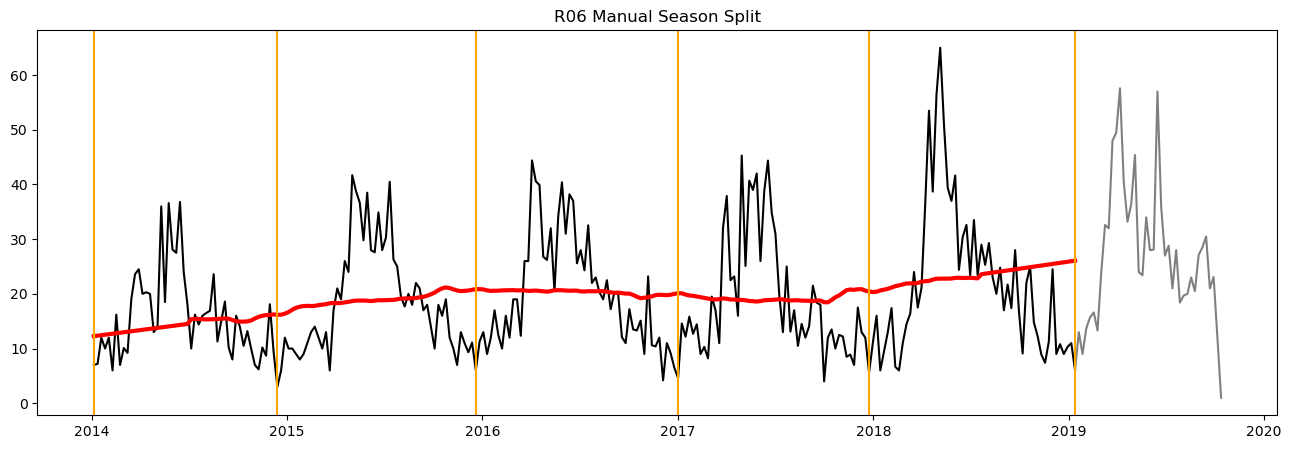

In [42]:
plt.figure(figsize=(16,5))
plt.plot(y_r06_hist,'k')
plt.plot(y_r06_future,'k',alpha=0.5)
plt.plot(trend,'r',linewidth=3)
for low in lows:
    plt.axvline(x=pd.to_datetime(low),color='orange')

plt.title(med_name + " Manual Season Split")
# plt.savefig(med_name + "-season-manual-split.png")

#### Divide the detrended data into seasons

In [43]:
period = int(np.round(np.mean(np.diff(lows_index))))
num_seasons = len(lows)-1
print(period)
print(num_seasons)

52
5


In [44]:
seasonals = np.empty((period,num_seasons))
for p in range(num_seasons):
    s = detrended[lows_index[p]:lows_index[p]+period]
    s = 2*(s-np.min(s))/(np.max(s)-np.min(s))
    seasonals[:,p] = s
    
mean_seasonals = seasonals.mean(axis=1)

Text(0.5, 1.0, 'R06 Manual Mean Seasonal')

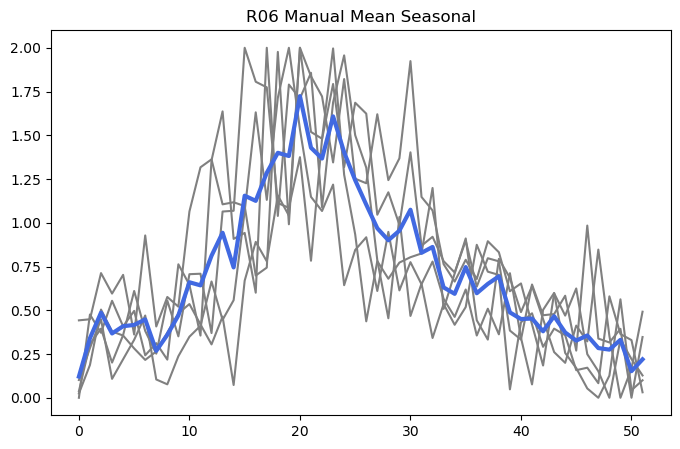

In [45]:
plt.figure(figsize=(8,5))
for p in range(num_seasons):
    plt.plot(seasonals[:,p],color=0.5*np.ones(3))
plt.plot(mean_seasonals,color='royalblue',linewidth=3)
plt.title(med_name + " Manual Mean Seasonal")
# plt.savefig(med_name + "-season-manual-mean.png")

#### Smooth the seasonal data

In [46]:
filt_size = 2
filt = np.repeat(1.0 / filt_size, filt_size)

seasonals = np.empty((period,num_seasons))
for p in range(num_seasons):
    s = detrended[lows_index[p]:lows_index[p]+period]
    s = convolution_filter(s, filt)
    s = _extrapolate_trend(s, filt_size)
    s = (s-np.min(s))/(np.max(s)-np.min(s))
    seasonals[:,p] = s
    
mean_seasonals = seasonals.mean(axis=1)

Text(0.5, 1.0, 'R06 Manual Season Smoothing')

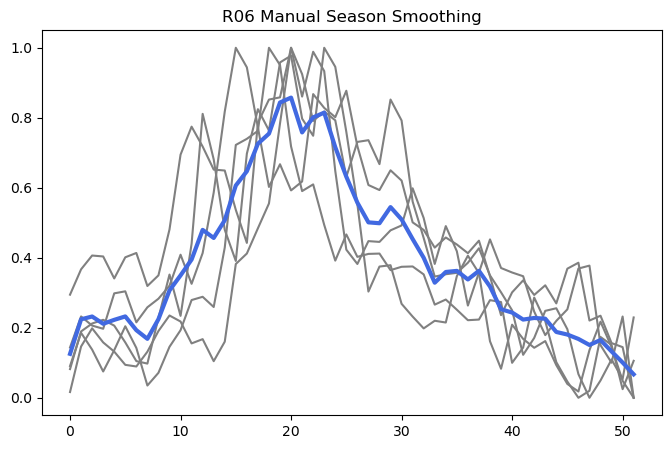

In [47]:
plt.figure(figsize=(8,5))
for p in range(num_seasons):
    plt.plot(seasonals[:,p],color=0.5*np.ones(3))
plt.plot(mean_seasonals,color='royalblue',linewidth=3)
plt.title(med_name + " Manual Season Smoothing")
# plt.savefig(med_name + "-season-manual-smoothing.png")

#### Remove outliers

In [48]:
seasonals = seasonals[:,[0, 1, 2, 3, 4]]
mean_seasonals = seasonals.mean(axis=1)

Text(0.5, 1.0, 'R06 Manual Season Outliers')

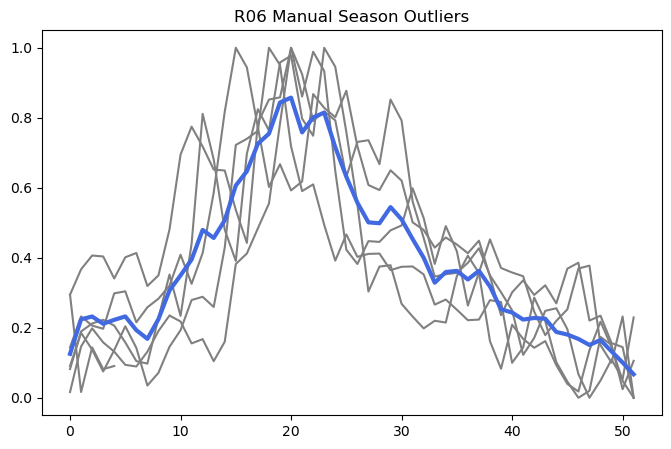

In [49]:
plt.figure(figsize=(8,5))
plt.plot(seasonals[0],color=0.5*np.ones(3),label='historical data')
plt.plot(seasonals,color=0.5*np.ones(3))
plt.plot(mean_seasonals,color='royalblue',linewidth=3)
plt.title(med_name + " Manual Season Outliers")
# plt.savefig(med_name + "-season-manual-outliers.png")

#### Build the seasonal template

In [50]:
seasonal = pd.Series(index=y_r06_hist.index,data=0)

for low in lows_index:
    if low+period<len(seasonal):
        seasonal[low:low+period] = mean_seasonals
    else:
        seasonal[low:] = mean_seasonals[:len(seasonal)-(low+period)]
        
seasonal = seasonal / np.max(seasonal)

Text(0.5, 1.0, 'R06 Manual Season Template')

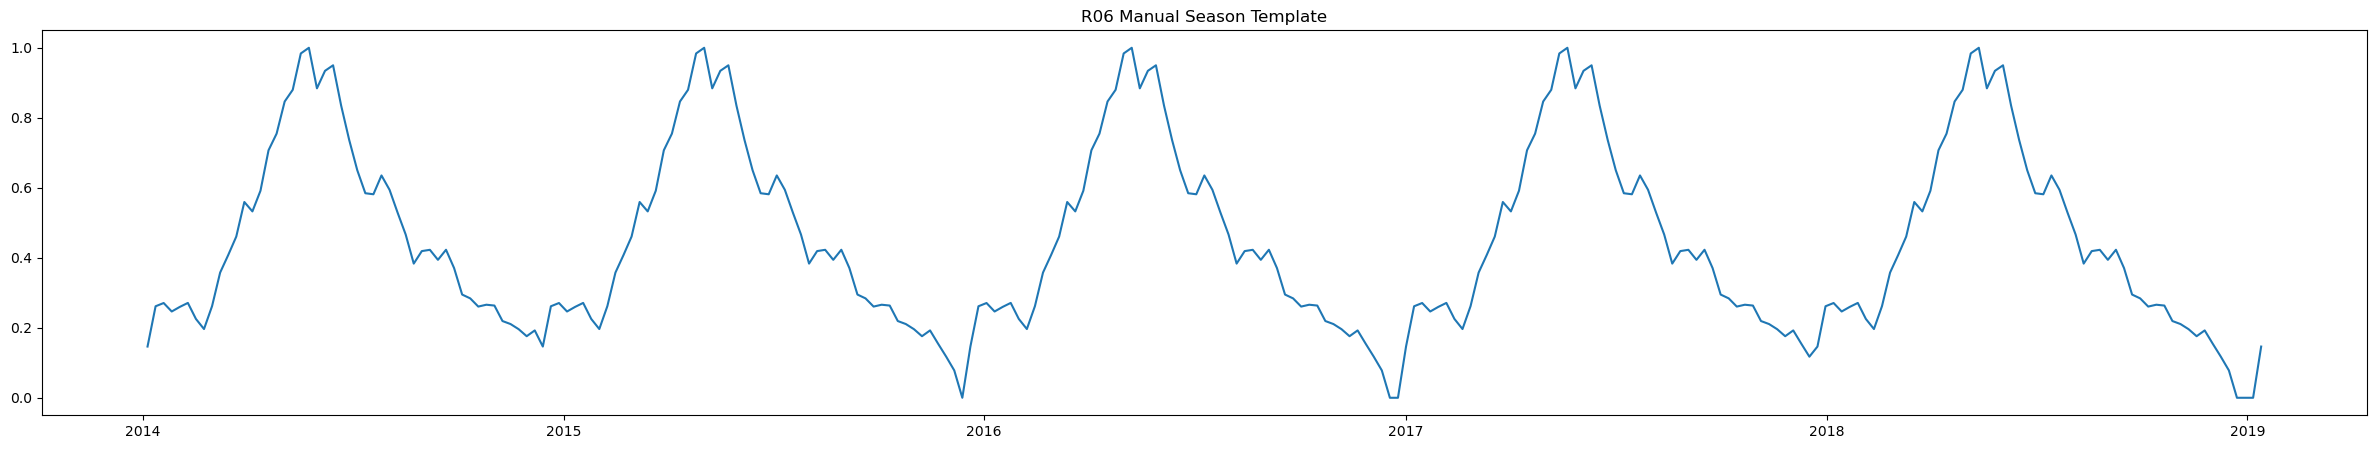

In [51]:
plt.figure(figsize=(30,5))
plt.plot(seasonal)
plt.title(med_name + " Manual Season Template")
# plt.savefig(med_name + "-season-manual-template.png")

#### Final model

In [52]:
# season_and_trend = 2*trend*seasonal
season_and_trend = 2 * trend * seasonal

In [53]:
manual_decomp_end = process_time()
manual_decomp_fit_time = manual_decomp_end - manual_decomp_start
print(manual_decomp_fit_time)

1.1249655569999994


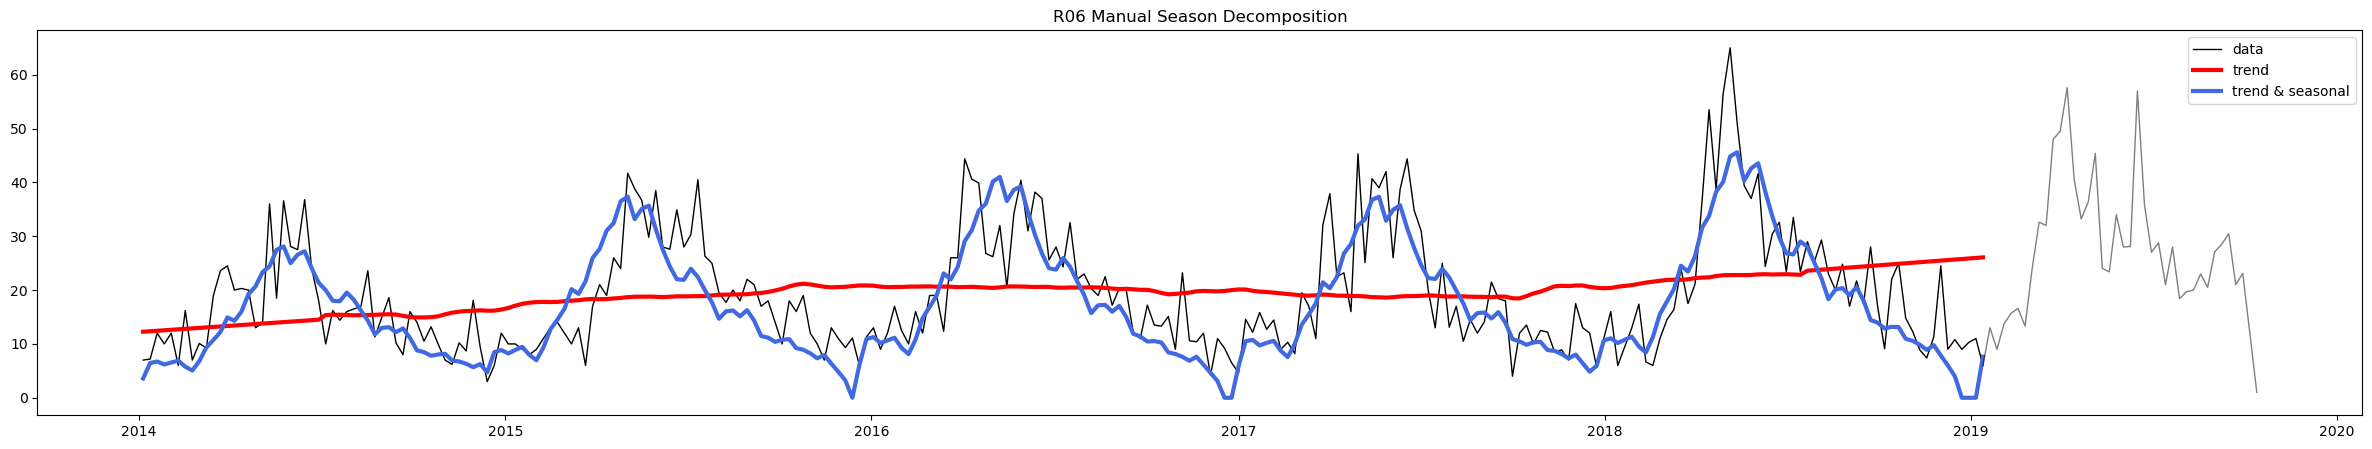

In [54]:
plt.figure(figsize=(30,5))
plt.plot(y_r06_hist,'k',label='data',linewidth=1)
plt.plot(trend,label='trend',color='red',linewidth=3)
plt.plot(season_and_trend,label='trend & seasonal',color='royalblue',linewidth=3)
plt.plot(y_r06_future,'k',alpha=0.5,linewidth=1)
plt.title(med_name + " Manual Season Decomposition")
plt.savefig(med_name + "-decomp-model-manual.png")
plt.legend()

#### Model residue

In [55]:
residue = y_r06_hist - season_and_trend

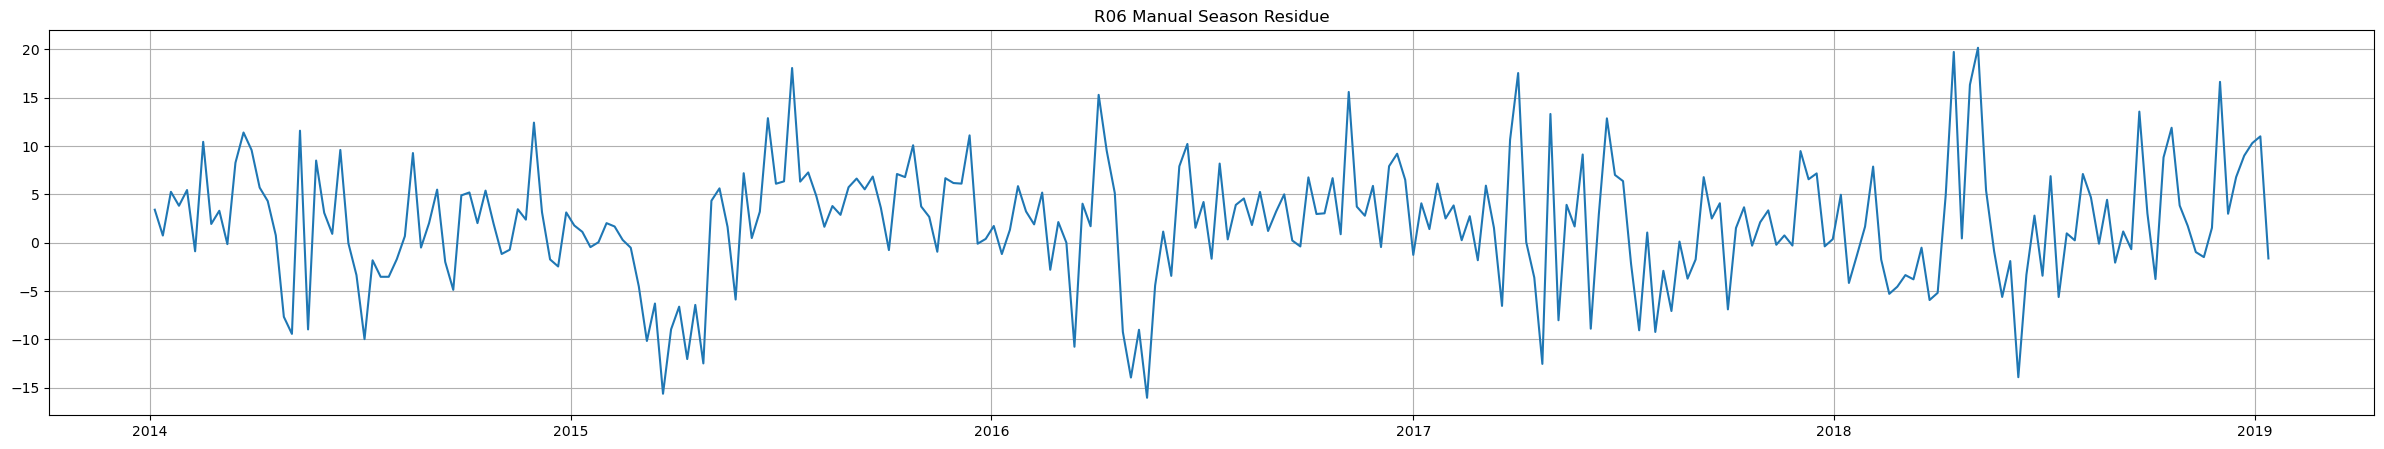

In [56]:
plt.figure(figsize=(30,5))
plt.plot(residue)
plt.grid()
plt.savefig("R06-residue-manual.png")
plt.title(med_name + " Manual Season Residue")
plt.savefig(med_name + "-residue-model-manual.png")

#### Size of the residue

In [57]:
man_decomp_residue_MAEm = np.abs(residue).mean()
man_decomp_residue_RMSEm = np.sqrt( np.square(residue).mean() )
man_decomp_residue_MAEm, man_decomp_residue_RMSEm

(5.010216912083399, 6.5137814292322815)

#### Stationarity of the residue

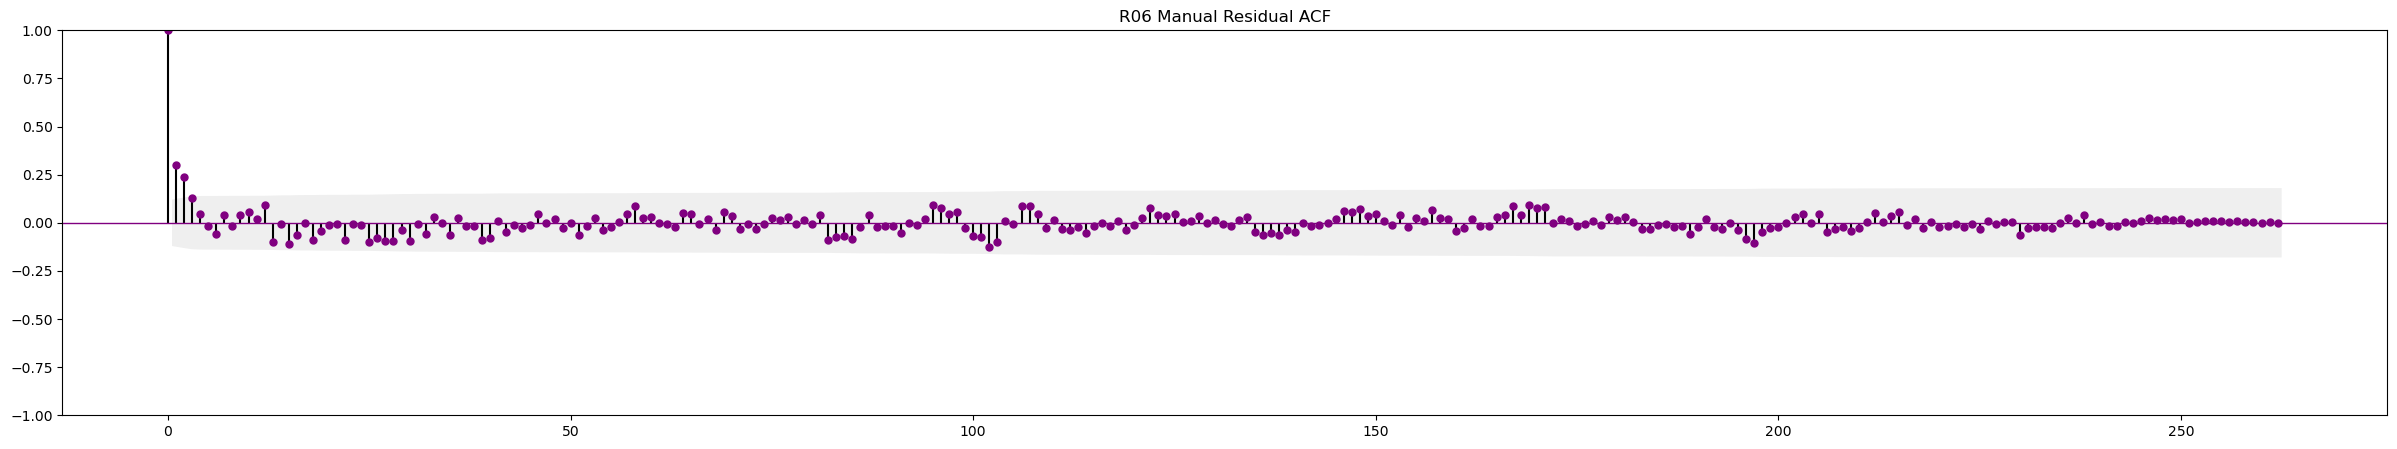

In [58]:
# _, ax = plt.subplots(figsize=(30,5))
# tsplots.plot_acf(residue,lags=262, ax=ax)
# plt.show()

f, ax = plt.subplots(figsize=(30,5))
plot_acf(residue, lags=262, ax=ax)
ax = plot_acf_colors(ax)
plt.title(med_name + " Manual Residual ACF")
plt.savefig(med_name + "-manual-residual-acf.png")

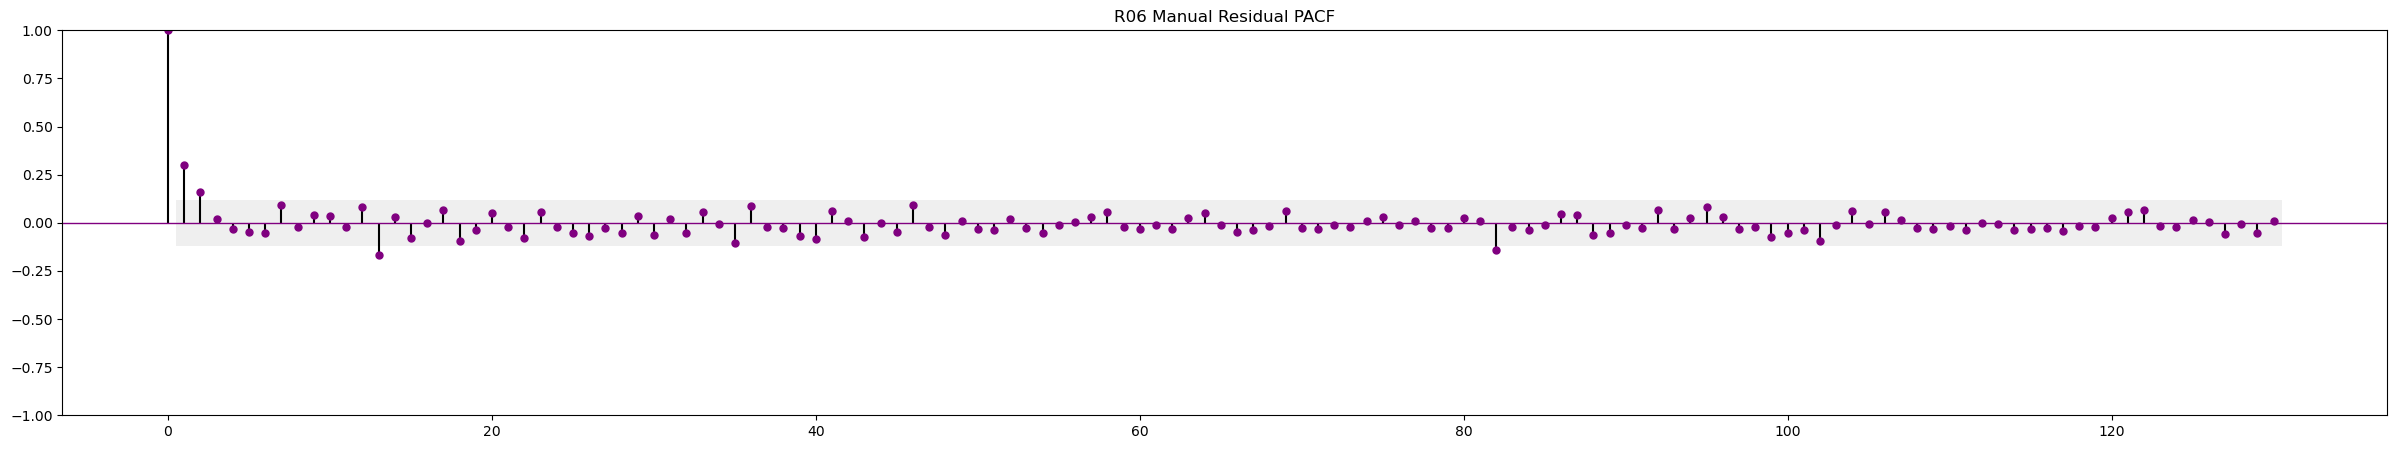

In [59]:
f, ax = plt.subplots(figsize=(30, 5))
plot_pacf(residue, lags=130, ax=ax)
ax = plot_acf_colors(ax)
plt.title(med_name + " Manual Residual PACF")
plt.savefig(med_name + "-manual-residual-pacf.png")

In [60]:
adf_test = adfuller(residue)
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])
adf_test

ADF Statistic: -8.068649
p-value: 0.000000


(-8.0686492622153,
 1.5711688481398923e-12,
 1,
 261,
 {'1%': -3.4556556713934934,
  '5%': -2.872678352489859,
  '10%': -2.57270548832225},
 1578.8724866792818)

Residue is stationary

#### Forecast

In [61]:
f = len(y_r06_future)
f_periods = int(1 + f/period)
yhat_trend = pd.Series(index=y_r06_future.index, data=trend[-1])

In [62]:
yhat_seasonal = pd.Series(index=y_r06_future.index)
for i in range(len(yhat_seasonal)):
    yhat_seasonal[i] = seasonal[-(f_periods*len(mean_seasonals)-i)]

In [63]:
yhat = 2*yhat_trend*yhat_seasonal

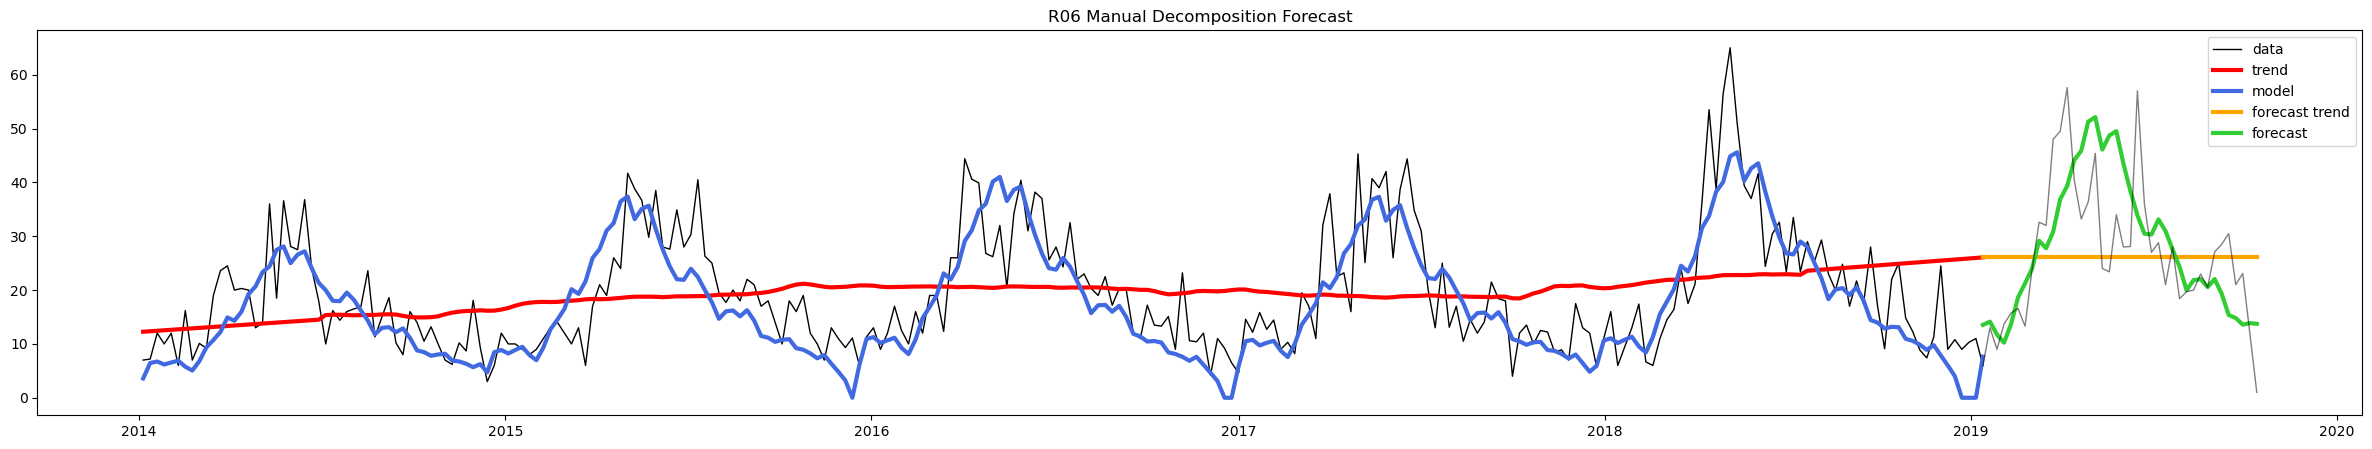

In [64]:
plt.figure(figsize=(30,5))
plt.plot(y_r06_hist,'k',label='data',linewidth=1)
plt.plot(trend,label='trend',color='red',linewidth=3)
plt.plot(season_and_trend,label='model',color='royalblue',linewidth=3)
plt.plot(yhat_trend,label='forecast trend',color='orange',linewidth=3)
plt.plot(yhat,label='forecast',color='limegreen',linewidth=3)
plt.plot(y_r06_future,'k',alpha=0.5,linewidth=1)
plt.legend();
plt.title(med_name + " Manual Decomposition Forecast")
plt.savefig(med_name + "-manual-decomp-forecast.png")

#### Prediction error

In [65]:
pred_error = y_r06_future - yhat

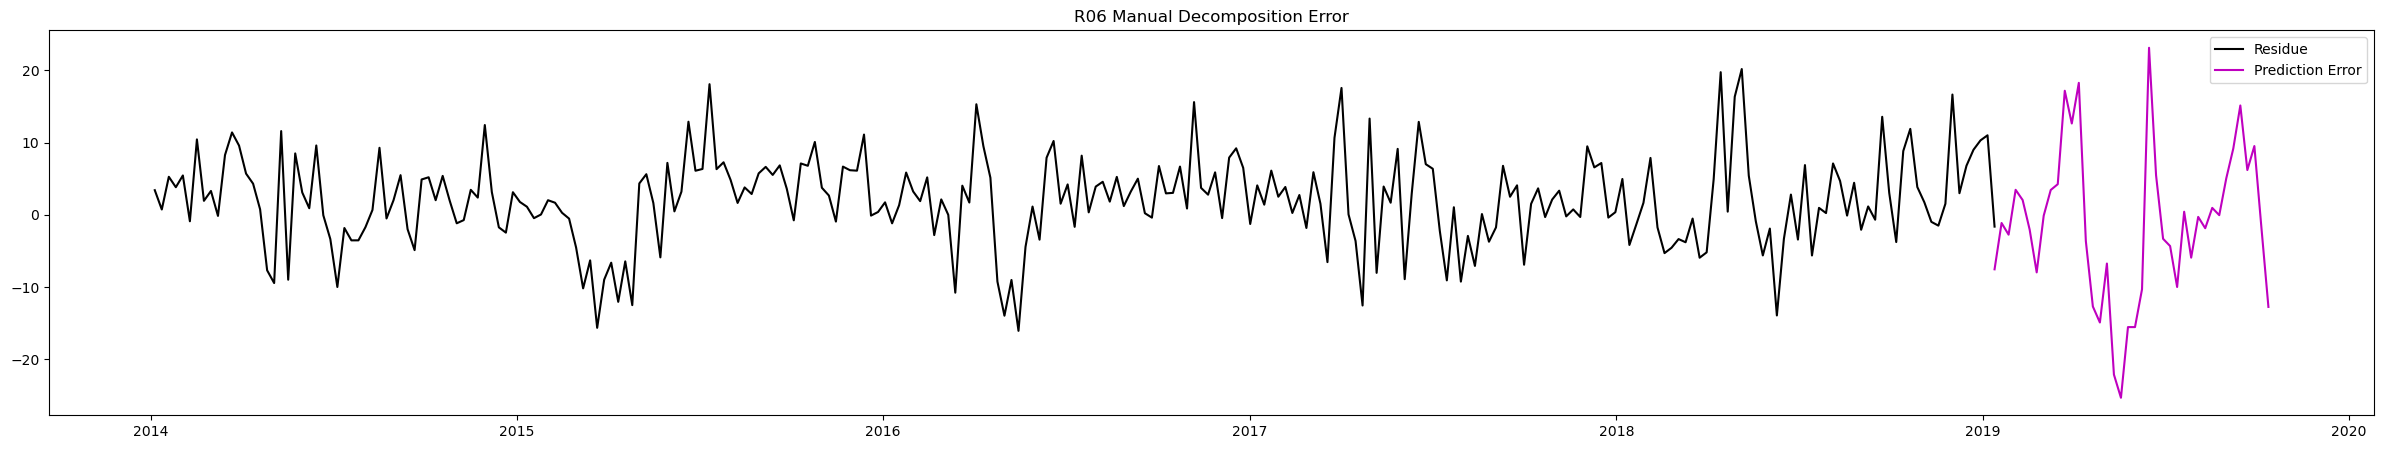

In [66]:
plt.figure(figsize=(30,5))
plt.plot(residue,'k',label='Residue')
plt.plot(pred_error,'m',label='Prediction Error')
plt.legend();
plt.title(med_name + " Manual Decomposition Error")
plt.savefig(med_name + "-manual-decomp-error.png")

#### Score the Model

In [67]:
man_decomp_pred_MAEp = np.abs(pred_error).mean()
man_decomp_pred_RMSEp = np.sqrt( np.square(pred_error).mean())
man_decomp_pred_MAEp, man_decomp_pred_RMSEp

(8.116364753990501, 10.593812462238713)

### Model Comparisons

In [68]:
results_df.loc['Baseline-Statsmodel Decomposition', ['train time']] = tsa_fit_time
results_df.loc['Baseline-Statsmodel Decomposition', ['train MAE']] = tsa_residue_MAEm
results_df.loc['Baseline-Statsmodel Decomposition', ['test MAE']] = tsa_decomp_pred_MAEp
results_df.loc['Baseline-Statsmodel Decomposition', ['train RMSE']] = tsa_residue_RMSEm
results_df.loc['Baseline-Statsmodel Decomposition', ['test RMSE']] = tsa_decomp_pred_RMSEp

results_df.loc['Manual Decomposition', ['train time']] = manual_decomp_fit_time
results_df.loc['Manual Decomposition', ['train MAE']] = man_decomp_residue_MAEm
results_df.loc['Manual Decomposition', ['test MAE']] = man_decomp_pred_MAEp
results_df.loc['Manual Decomposition', ['train RMSE']] = man_decomp_residue_RMSEm
results_df.loc['Manual Decomposition', ['test RMSE']] = man_decomp_pred_RMSEp

results_df

train time  train MAE  test MAE  \
model                                                                
Baseline-Statsmodel Decomposition    0.002082   4.681426  6.141950   
Manual Decomposition                 1.124966   5.010217  8.116365   
ARMA                                 0.000000   0.000000  0.000000   
SARIMAX                              0.000000   0.000000  0.000000   
Dense                                0.000000   0.000000  0.000000   
RNN                                  0.000000   0.000000  0.000000   
LSTM                                 0.000000   0.000000  0.000000   
Conv1D                               0.000000   0.000000  0.000000   
LSTM2                                0.000000   0.000000  0.000000   

                                   train RMSE  test RMSE  
model                                                     
Baseline-Statsmodel Decomposition    6.102017   7.830218  
Manual Decomposition                 6.513781  10.593812  
ARMA                                 0.000000   0.000000  
SARIMAX                              0.000000   0.000000  
Dense                                0.000000   0.000000  
RNN                                  0.000000   0.000000  
LSTM                                 0.000000   0.000000  
Conv1D                               0.000000   0.000000  
LSTM2                                0.000000   0.000000

### Improving the Model

### ARMA

In [69]:
r06_residual = r06_recon_df[['residual']]
r06_residual

residual
datum                
2014-01-05   4.497688
2014-01-12   2.693591
2014-01-19   9.218661
2014-01-26   4.478880
2014-02-02   7.280178
...               ...
2019-09-15   8.998833
2019-09-22  -1.068108
2019-09-29   4.882099
2019-10-06  -4.320579
2019-10-13 -16.002264

[302 rows x 1 columns]

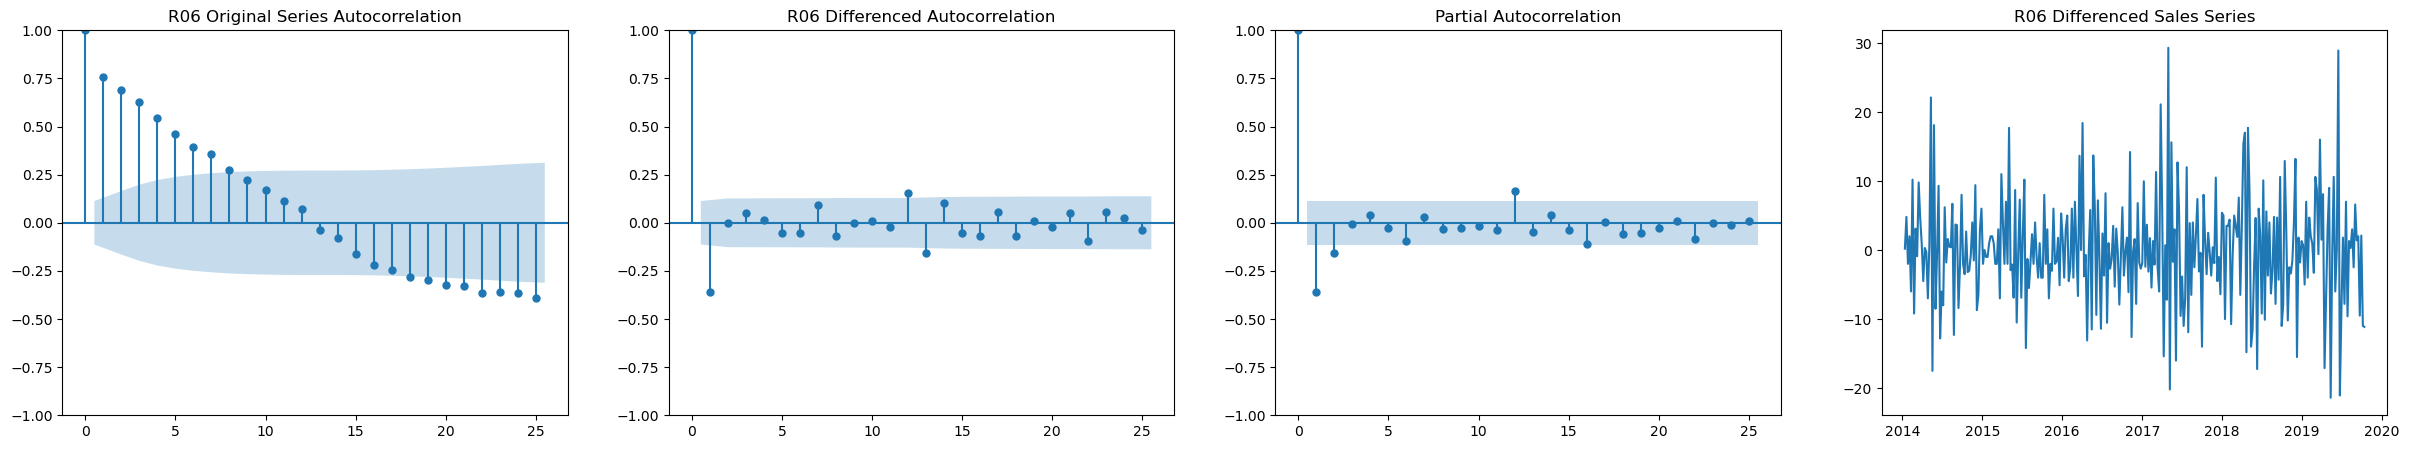

In [70]:
fig, ax = plt.subplots(1, 4, figsize = (30, 5))
plot_acf(df_r06_weekly['values'], ax = ax[0]);
ax[0].set_title(med_name + ' Original Series Autocorrelation')
plot_acf(df_r06_weekly['values'].diff().dropna(), ax = ax[1]);
ax[1].set_title(med_name + ' Differenced Autocorrelation')
plot_pacf(df_r06_weekly['values'].diff().dropna(), ax = ax[2], method = 'ywm');
ax[3].plot(df_r06_weekly['values'].diff().dropna())
ax[3].set_title(med_name + ' Differenced Sales Series');
plt.savefig(med_name + "-differenced-series.png")

In [71]:
from pandas.plotting import autocorrelation_plot

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

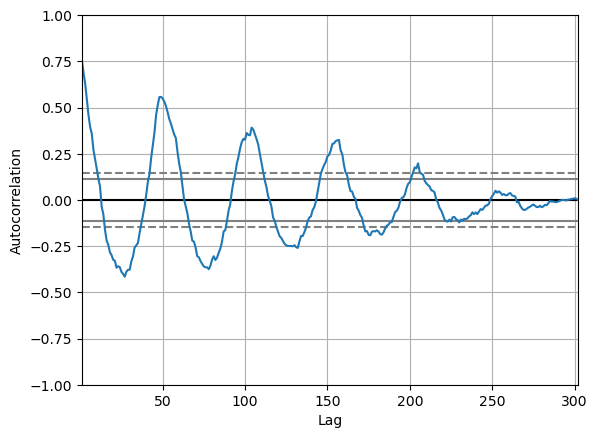

In [72]:
autocorrelation_plot(df_r06_weekly)

In [73]:
X_train = y_r06_hist
X_test = y_r06_future

* p: The lag order, representing the number of lag observations incorporated in the model.
* d: Degree of differencing, denoting the number of times raw observations undergo differencing.
* q: Order of moving average, indicating the size of the moving average window.

In [74]:
p = 52
d = 1
q = 2

arma_start = process_time()
# arma = ARIMA(X_train.diff(), order = (1, 0, 1), freq = 'W').fit()
arma = ARIMA(X_train.diff(), order = (p, d, q), freq = 'W').fit()
arma_end = process_time()

arma_fit_time = arma_end - arma_start

arma_train_preds = arma.forecast(len(X_train))
arma_mse_train = mean_squared_error(arma_train_preds, X_train)
arma_mae_train = mean_absolute_error(X_train, arma_train_preds)
arma_rmse_train = np.sqrt(arma_mse_train)

arma_preds = arma.forecast(len(X_test))
arma_mse_test = mean_squared_error(arma_preds, X_test)
arma_mae_test = mean_absolute_error(X_test, arma_preds)
arma_rmse_test = np.sqrt(arma_mse_test)

print(arma_fit_time)

print(arma_preds[:5])

print(arma_mse_train)
print(arma_mae_train)
print(arma_rmse_train)

print(arma_mse_test)
print(arma_mae_test)
print(arma_rmse_test)

237.24235549
2019-01-20    3.629700
2019-01-27   -3.267514
2019-02-03   -4.816203
2019-02-10    9.254708
2019-02-17    1.687925
Freq: W-SUN, Name: predicted_mean, dtype: float64
494.9404936446648
19.092910278614386
22.247258115207472
872.0252034365461
26.422316822009872
29.53007286541207


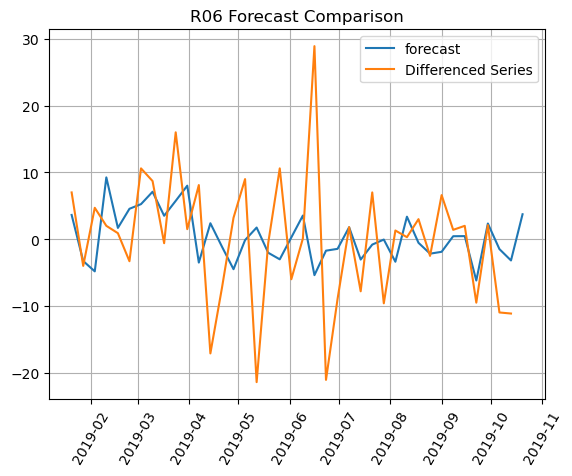

In [75]:
plt.plot(arma_preds, label = 'forecast')
plt.plot(X_test.diff(), label = 'Differenced Series')
# plt.plot(X_test, label = 'observed')
plt.legend();
plt.xticks(rotation = 60)
plt.grid();
plt.title(med_name + " Forecast Comparison")
plt.savefig(med_name + '-' + str(p) + '-' + str(d)+ '-' + str(q) + "-arma-forecast.png")

##### Grid Search ARMA models

In [76]:
def evaluate_arima_model(X, arima_order):
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    error = np.sqrt(mean_squared_error(test, predictions))
    print('pdq:' + str(arima_order) + ' rmse:' + str(error))
    return error

In [77]:
def grid_search_arima_models(f, dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                rmse = evaluate_arima_model(dataset, order)
                if rmse < best_score:
                    best_score, best_cfg = rmse, order
    print(f+' - Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    return best_cfg

In [78]:
arma_p_values = [0,1]
arma_d_values = range(0, 2)
arma_q_values = range(0, 3)

order = grid_search_arima_models(med_name, df_r06_weekly['values'].values, arma_p_values, arma_d_values, arma_q_values)

print('pdq:' + str(order))
X = df_r06_weekly['values'].values
train_size = int(len(X) * 0.8)
train, test = X[0:train_size], X[train_size:]
history = [x for x in train]
observed = []
train_predictions = list()
test_predictions = list()

for t in range(len(train)):
    model = ARIMA(history, order=order)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    train_predictions.append(yhat)
    observed.append(train[t])
    
best_arma_rmse_train = np.sqrt(mean_squared_error(observed, train_predictions))
best_arma_mae_train = mean_absolute_error(observed, train_predictions)

start = process_time()
for t in range(len(test)):
    model = ARIMA(history, order=order)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    test_predictions.append(yhat)
    history.append(test[t])
end = process_time()

best_arma_fit_time = end - start
best_arma_rmse_test = np.sqrt(mean_squared_error(test, test_predictions))
best_arma_mae_test = mean_absolute_error(test, test_predictions)

pdq:(0, 0, 0) rmse:12.49214757374402
pdq:(0, 0, 1) rmse:9.827459096485184
pdq:(0, 0, 2) rmse:9.47555866592939
pdq:(0, 1, 0) rmse:8.889222614409237
pdq:(0, 1, 1) rmse:8.521990248109871
pdq:(0, 1, 2) rmse:8.593663397594602
pdq:(1, 0, 0) rmse:8.41658257053221
pdq:(1, 0, 1) rmse:8.329711060707748
pdq:(1, 0, 2) rmse:8.40592422374508
pdq:(1, 1, 0) rmse:8.705044586125917
pdq:(1, 1, 1) rmse:8.583132976971658
pdq:(1, 1, 2) rmse:8.599400918868792
R06 - Best ARIMA(1, 0, 1) RMSE=8.330
pdq:(1, 0, 1)


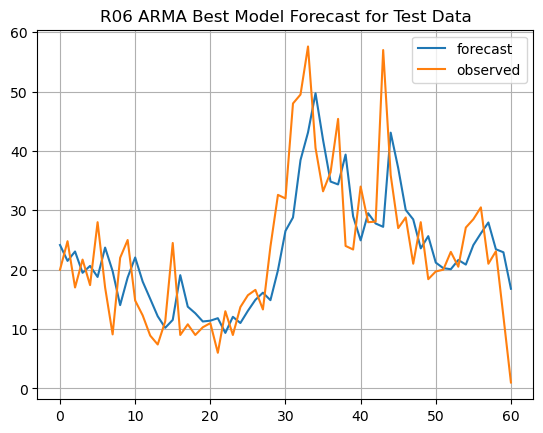

In [79]:
plt.plot(test_predictions, label = 'forecast')
plt.plot(test, label = 'observed')
# plt.plot(X_test, label = 'observed')
plt.legend();
plt.grid();
plt.title(med_name + " ARMA Best Model Forecast for Test Data")
plt.savefig(med_name + '-' + str(order[0]) + '-' + str(order[1])+ '-' + str(order[2]) + "-arma-forecast-test.png")

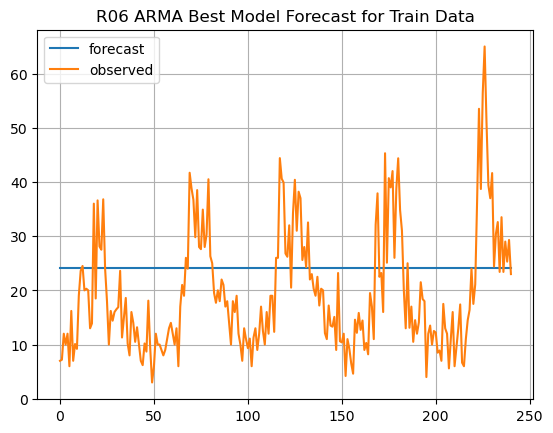

In [80]:
plt.plot(train_predictions, label = 'forecast')
plt.plot(train, label = 'observed')
# plt.plot(X_test, label = 'observed')
plt.legend();
plt.grid();
plt.title(med_name + " ARMA Best Model Forecast for Train Data")
plt.savefig(med_name + '-' + str(order[0]) + '-' + str(order[1])+ '-' + str(order[2]) + "-arma-forecast-train.png")

In [81]:
results_df.loc['ARMA', ['train time']] = best_arma_fit_time
results_df.loc['ARMA', ['train MAE']] = best_arma_mae_train
results_df.loc['ARMA', ['test MAE']] = best_arma_mae_test
results_df.loc['ARMA', ['train RMSE']] = best_arma_rmse_train
results_df.loc['ARMA', ['test RMSE']] = best_arma_rmse_test

results_df

train time  train MAE  test MAE  \
model                                                                
Baseline-Statsmodel Decomposition    0.002082   4.681426  6.141950   
Manual Decomposition                 1.124966   5.010217  8.116365   
ARMA                                 3.800801  10.305064  6.469667   
SARIMAX                              0.000000   0.000000  0.000000   
Dense                                0.000000   0.000000  0.000000   
RNN                                  0.000000   0.000000  0.000000   
LSTM                                 0.000000   0.000000  0.000000   
Conv1D                               0.000000   0.000000  0.000000   
LSTM2                                0.000000   0.000000  0.000000   

                                   train RMSE  test RMSE  
model                                                     
Baseline-Statsmodel Decomposition    6.102017   7.830218  
Manual Decomposition                 6.513781  10.593812  
ARMA                                11.986801   8.329711  
SARIMAX                              0.000000   0.000000  
Dense                                0.000000   0.000000  
RNN                                  0.000000   0.000000  
LSTM                                 0.000000   0.000000  
Conv1D                               0.000000   0.000000  
LSTM2                                0.000000   0.000000

### SARIMAX

The seasonal order in a SARIMA (Seasonal Autoregressive Integrated Moving Average) model consists of four parameters: (D, P, Q, M). These parameters are used to capture the seasonal patterns in the time series data. Here’s a brief explanation of each parameter:

* D: This parameter represents the degree of seasonal differencing. It is used to remove any seasonal trends or patterns in the data. For example, if the data is seasonal on a monthly basis and shows an upward trend every year, then setting D=1 would make the data stationary.
* P: This parameter represents the order of the seasonal autoregressive component. It indicates how many lagged values of the seasonal component are used to predict the current value. For example, if P=2, then the model will use the previous two seasonal values to predict the current seasonal value.
* Q: This parameter represents the order of the seasonal moving average component. It indicates how many lagged values of the seasonal error term are used to predict the current value. For example, if Q=1, then the model will use the previous seasonal error term to predict the current seasonal error term.
* M: This parameter represents the length of the seasonal period. It determines the number of time periods that make up a complete cycle. For example, if the data is monthly and the seasonal pattern repeats every year, then M=12.

#### Perform Grid Search on the Sarimax Model
I was inspired by the tutorial below on how to perform grid search on a sarimax model.  I tried to implement this grid search, however, I ran into problems and was not able to complete the process successfully.

https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/

This model has hyperparameters that control the nature of the model performed for the series, trend and seasonality, specifically:

* order: A tuple p, d, and q parameters for the modeling of the trend.
* sesonal_order: A tuple of P, D, Q, and m parameters for the modeling the seasonality
* trend: A parameter for controlling a model of the deterministic trend as one of ‘n’,’c’,’t’,’ct’ for no trend, constant, linear, and constant with linear trend, respectively.

Parameters that hung the process:
* trend ct
* seasonal 20, 52
* PDQ = 2, 1, 2

##### Note:
This gridsearch mechanism is a great idea.  However, the process hangs frequently on my computer where the straight SARIMAX call returns a result in a short amount of time.  In the future, I would like to examine the process further and adapt it for a consistent successful run on my PC.

##### Homegrown solution
I attempted to create a home-grown grid search process by cobbling together concepts that I learned from class and the internet.  I was able to find a fairly good solution given the time and resource limitations.  Next step would be to improve this process by iterating through a set of given parameters instead of loading the permutation of the parameters from a csv file.

In [82]:
sarima_preds = []
sarima_params = []
print(sarima_preds)
print(sarima_params)
print(len(sarima_preds))
print(len(sarima_params))

[]
[]
0
0


In [83]:
sarima_grid_params_df = pd.read_csv("sarima_grid_parameters.csv")
sarima_grid_params_df

p  d  q  P  D  Q   s   t
0  1  0  1  2  1  2   2   c
1  1  0  1  2  1  2   2   n
2  1  0  1  2  1  2   2   t
3  1  0  1  2  1  2   2  ct
4  1  0  1  2  1  2   4   c
5  1  0  1  2  1  2   6   c
6  1  0  1  2  1  2  12   c
7  1  0  1  2  1  2  52   c

In [84]:
sarima_grid_df = pd.DataFrame(columns=['fit time', 'MAE', 'RMSE','p','d','q','P','D','Q','s','t'])
sarima_grid_df

Empty DataFrame
Columns: [fit time, MAE, RMSE, p, d, q, P, D, Q, s, t]
Index: []

In [85]:
def plot_sarima(df, med, params, preds):
    num_plots = len(preds)
    fig, axs = plt.subplots(num_plots, 1, squeeze=False, figsize=(30, 5*num_plots))
    for i in range(0, num_plots):
        axs[i,0].set_title(med + " SARIMA Model Forecast for (pdq) " + str(params[i][0]) + ", (PDQs) " + str(params[i][1]) + " and t " + str(params[i][2]))
        axs[i,0].plot(df.index, preds[i], label = 'Forecast' )
        axs[i,0].plot(df.index, df, alpha = 0.3, label = 'Data')
        axs[i,0].grid()
        axs[i,0].legend()
        plt.savefig(med + " SARIMA Model Forecast for (pdq) " + str(params[i][0]) + ", (PDQs) " + str(params[i][1]) + " and t " + str(params[i][2]) + "-sarima-forecasts.png")
        
    plt.show()

--------------------------------------------
order:[1, 0, 1]
seasonal order:[2, 1, 2, 2]
MSE: 51.06534842178239
MAE: 5.427225086618461
RMSE: 7.146002268526256
--------------------------------------------
--------------------------------------------
order:[1, 0, 1]
seasonal order:[2, 1, 2, 2]
MSE: 51.201877328682336
MAE: 5.412172750893287
RMSE: 7.155548709126529
--------------------------------------------
--------------------------------------------
order:[1, 0, 1]
seasonal order:[2, 1, 2, 2]
MSE: 51.92636428431928
MAE: 5.458828190597081
RMSE: 7.205995023889433
--------------------------------------------
--------------------------------------------
order:[1, 0, 1]
seasonal order:[2, 1, 2, 2]
MSE: 52.27308608921509
MAE: 5.493876270949366
RMSE: 7.2300128692288705
--------------------------------------------
--------------------------------------------
order:[1, 0, 1]
seasonal order:[2, 1, 2, 4]
MSE: 52.06092242783537
MAE: 5.442526716072514
RMSE: 7.215325524731048
-----------------------

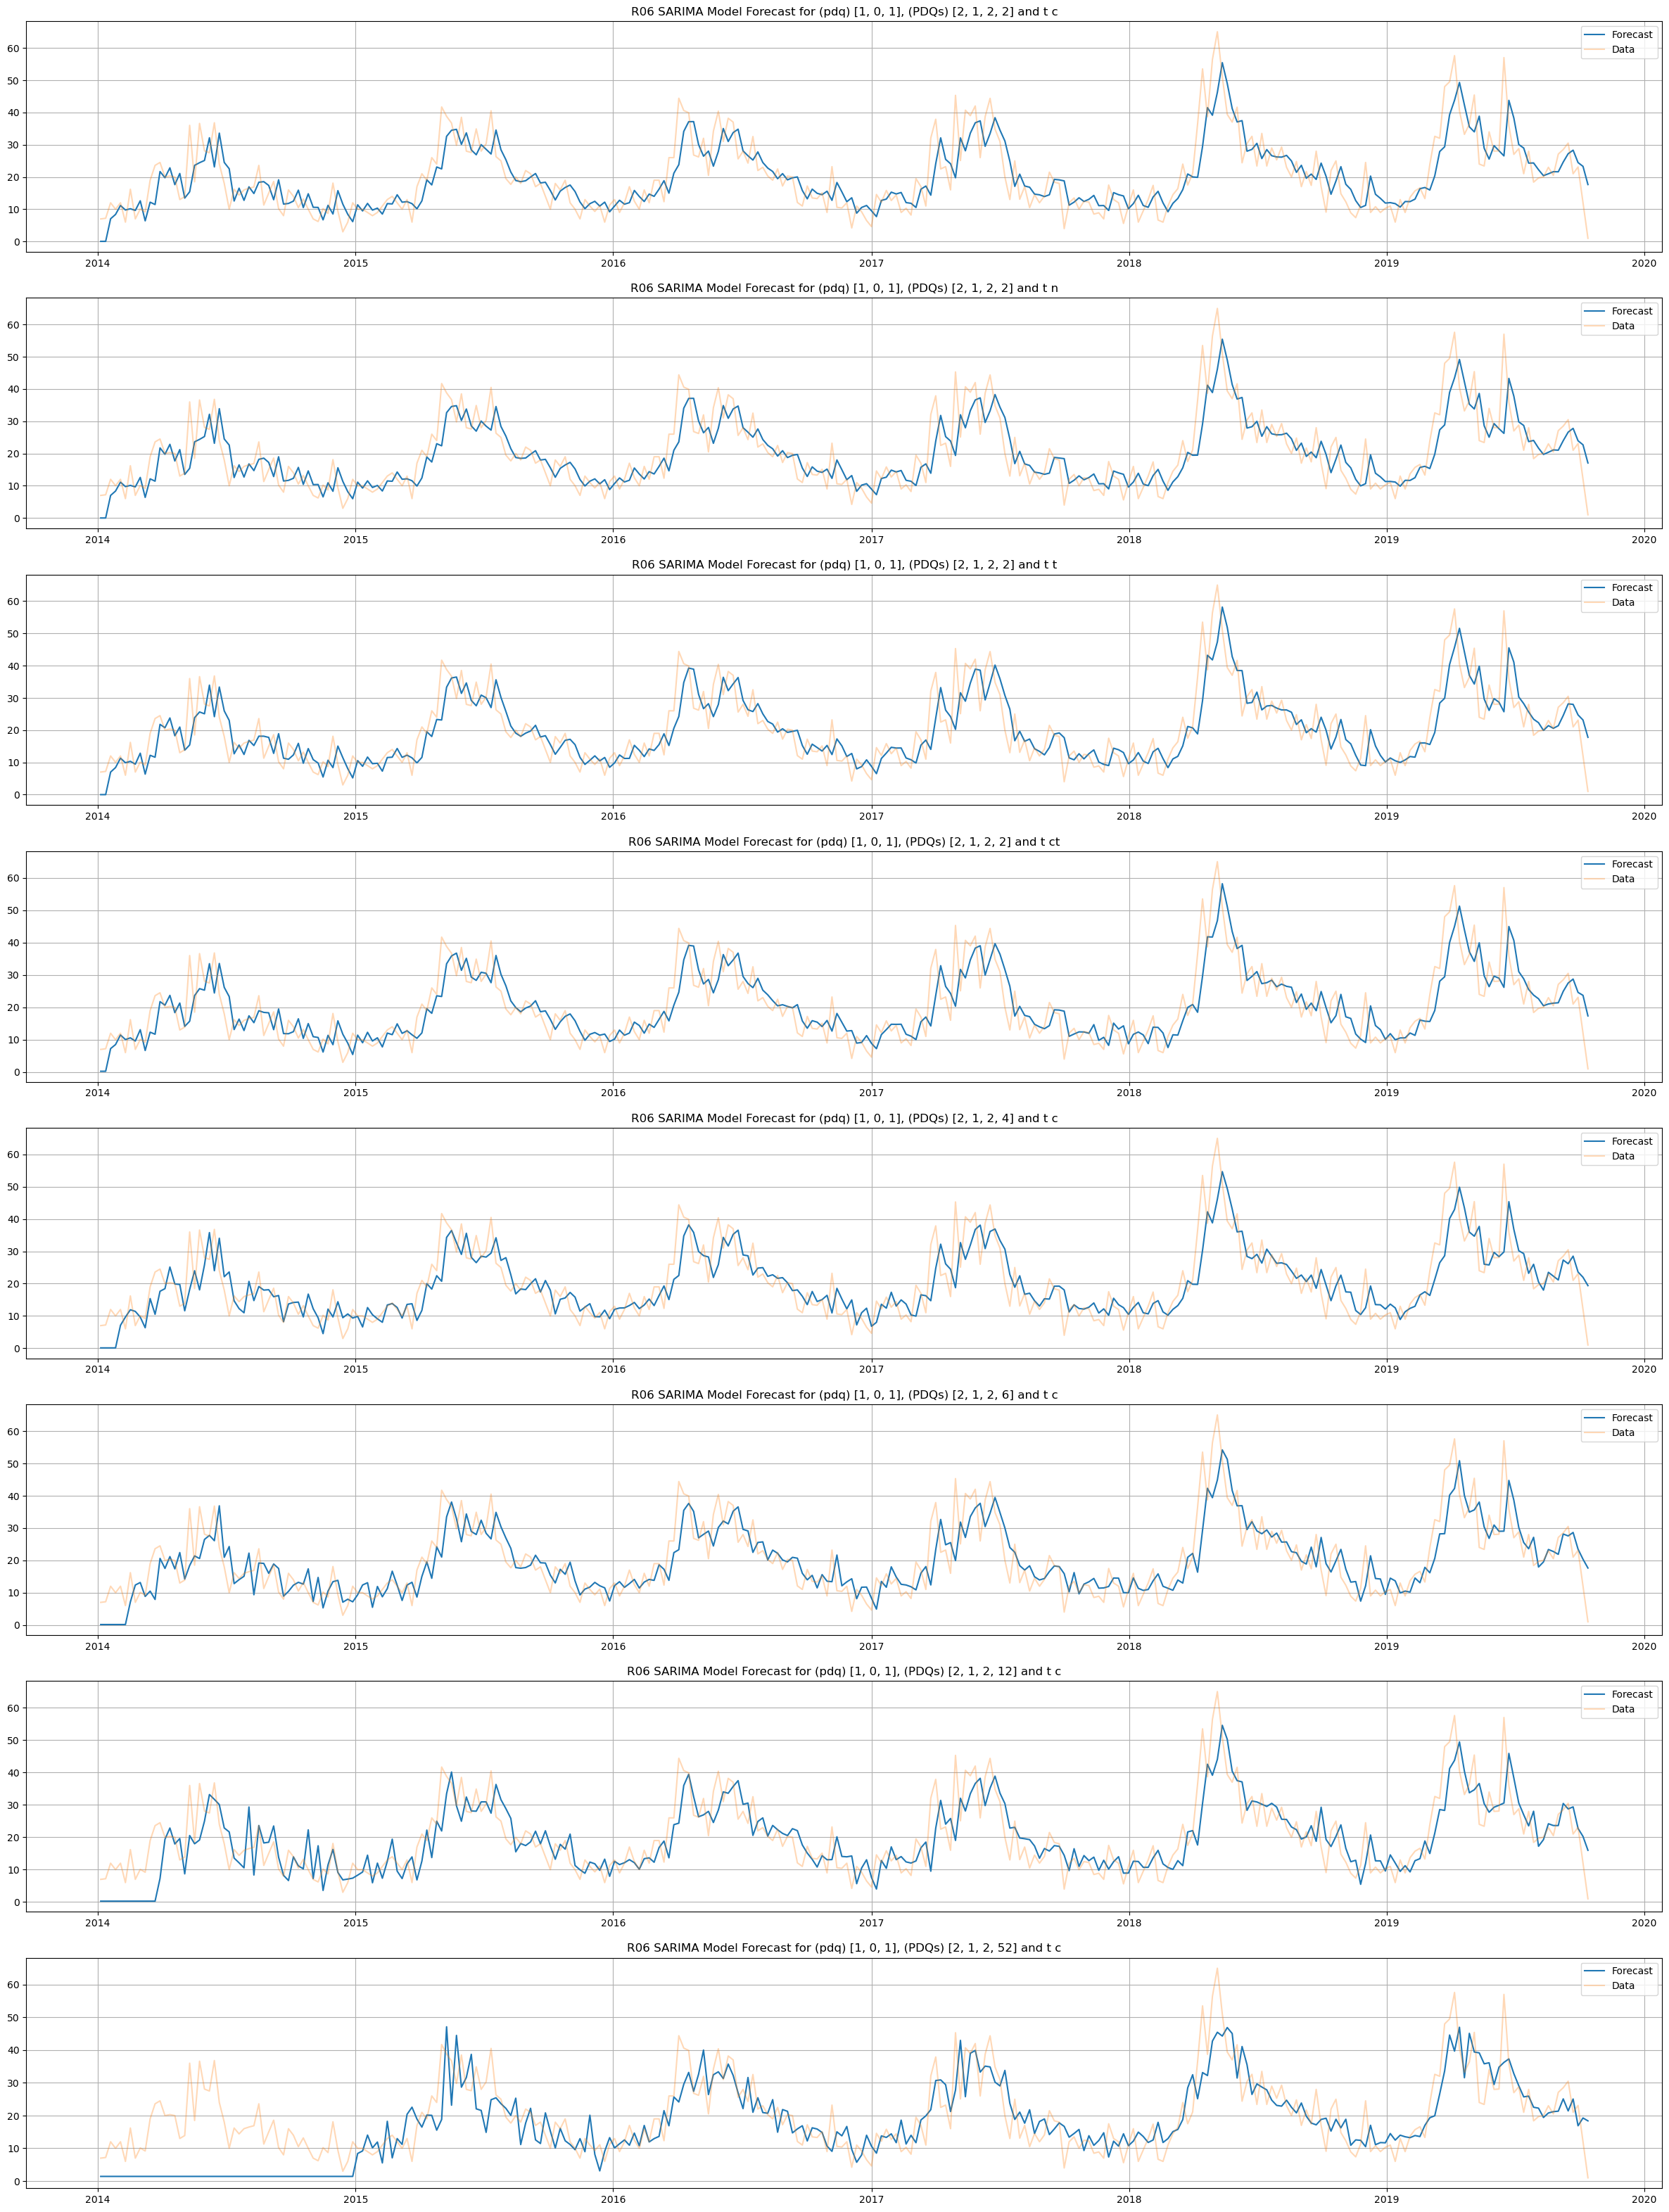

In [86]:
for row in sarima_grid_params_df.itertuples():
    # Extract grid parameters for sarimax
    p = row.p
    d = row.d
    q = row.q
    P = row.P
    D = row.D
    Q = row.Q
    s = row.s
    t = row.t

    # Construct order, seasonal order, and trend    
    sarima_seasonal_order = [P,D,Q,s]
    sarima_order = [p,d,q]
    sarima_trend = t

    # Train the sarimax model
    sarima_start = process_time()
    sarima = SARIMAX(df_r06_weekly,  order=sarima_order, seasonal_order=sarima_seasonal_order, trend=sarima_trend).fit(disp=0)
    sarima_end = process_time()

    # Measure performance
    sarima_fit_time = sarima_end - sarima_start
    sarima_prediction = sarima.predict()

    sarimax_mse_test = mean_squared_error(sarima_prediction, df_r06_weekly)
    sarimax_mae_test = mean_absolute_error(sarima_prediction, df_r06_weekly)
    sarimax_rmse_test = np.sqrt(mean_squared_error(sarima_prediction, df_r06_weekly))

    print('--------------------------------------------')
    print('order:' + str(sarima_order))
    print('seasonal order:' + str(sarima_seasonal_order))
    print('MSE: ' + str(sarimax_mse_test))
    print('MAE: ' + str(sarimax_mae_test))
    print('RMSE: ' + str(sarimax_rmse_test))
    print('--------------------------------------------')

    sarima_preds.append(sarima_prediction)

    # Track model performance in a dataframe
    new_row = pd.Series({'fit time': sarima_fit_time, 'MAE': sarimax_mae_test, 'RMSE': sarimax_rmse_test,'p': p,'d': d,'q': q,'P': P,'D': D,'Q': Q,'s': s, 't': t})
    sarima_grid_df = pd.concat([sarima_grid_df, new_row.to_frame().T], ignore_index=True)

    params = []
    params.append(sarima_order)
    params.append(sarima_seasonal_order)
    params.append(sarima_trend)

    sarima_params.append(params)

# plot model predictions
plot_sarima(df_r06_weekly,med_name,sarima_params, sarima_preds)

In [87]:
sarima_grid_df

fit time       MAE      RMSE  p  d  q  P  D  Q   s   t
0    2.309046  5.427225  7.146002  1  0  1  2  1  2   2   c
1    2.364521  5.412173  7.155549  1  0  1  2  1  2   2   n
2    2.406575  5.458828  7.205995  1  0  1  2  1  2   2   t
3    2.468314  5.493876  7.230013  1  0  1  2  1  2   2  ct
4     2.50515  5.442527  7.215326  1  0  1  2  1  2   4   c
5    2.762739  5.420445  7.279183  1  0  1  2  1  2   6   c
6     4.17376  5.761181  7.636566  1  0  1  2  1  2  12   c
7  255.364265  7.130721  9.423939  1  0  1  2  1  2  52   c

In [88]:
sarima_grid_df.to_csv('sarima_grid_df.csv', index=False)

#### Find the best sarimax model

In [89]:
best_sarima_model = sarima_grid_df.iloc[sarima_grid_df['RMSE'].idxmin()]
best_sarima_model

fit time    2.309046
MAE         5.427225
RMSE        7.146002
p                  1
d                  0
q                  1
P                  2
D                  1
Q                  2
s                  2
t                  c
Name: 0, dtype: object

In [90]:
results_df.loc['SARIMAX', ['train time']] = best_sarima_model['fit time']
results_df.loc['SARIMAX', ['train MAE']] = best_sarima_model['MAE']
results_df.loc['SARIMAX', ['test MAE']] = best_sarima_model['MAE']
results_df.loc['SARIMAX', ['train RMSE']] = best_sarima_model['RMSE']
results_df.loc['SARIMAX', ['test RMSE']] = best_sarima_model['RMSE']

results_df

train time  train MAE  test MAE  \
model                                                                
Baseline-Statsmodel Decomposition    0.002082   4.681426  6.141950   
Manual Decomposition                 1.124966   5.010217  8.116365   
ARMA                                 3.800801  10.305064  6.469667   
SARIMAX                              2.309046   5.427225  5.427225   
Dense                                0.000000   0.000000  0.000000   
RNN                                  0.000000   0.000000  0.000000   
LSTM                                 0.000000   0.000000  0.000000   
Conv1D                               0.000000   0.000000  0.000000   
LSTM2                                0.000000   0.000000  0.000000   

                                   train RMSE  test RMSE  
model                                                     
Baseline-Statsmodel Decomposition    6.102017   7.830218  
Manual Decomposition                 6.513781  10.593812  
ARMA                                11.986801   8.329711  
SARIMAX                              7.146002   7.146002  
Dense                                0.000000   0.000000  
RNN                                  0.000000   0.000000  
LSTM                                 0.000000   0.000000  
Conv1D                               0.000000   0.000000  
LSTM2                                0.000000   0.000000

### Neural Network

##### Scale the data

In [91]:
X = df_r06_weekly.drop(columns=df_r06_weekly.columns[0])
Y = df_r06_weekly[['values']]

In [92]:
# X

In [93]:
# Y

In [94]:
raw_data = Y['values'].values
data = raw_data

In [95]:
scaler = MinMaxScaler(feature_range=(0, 1))
raw_data = scaler.fit_transform(raw_data.reshape(-1, 1))
# raw_data

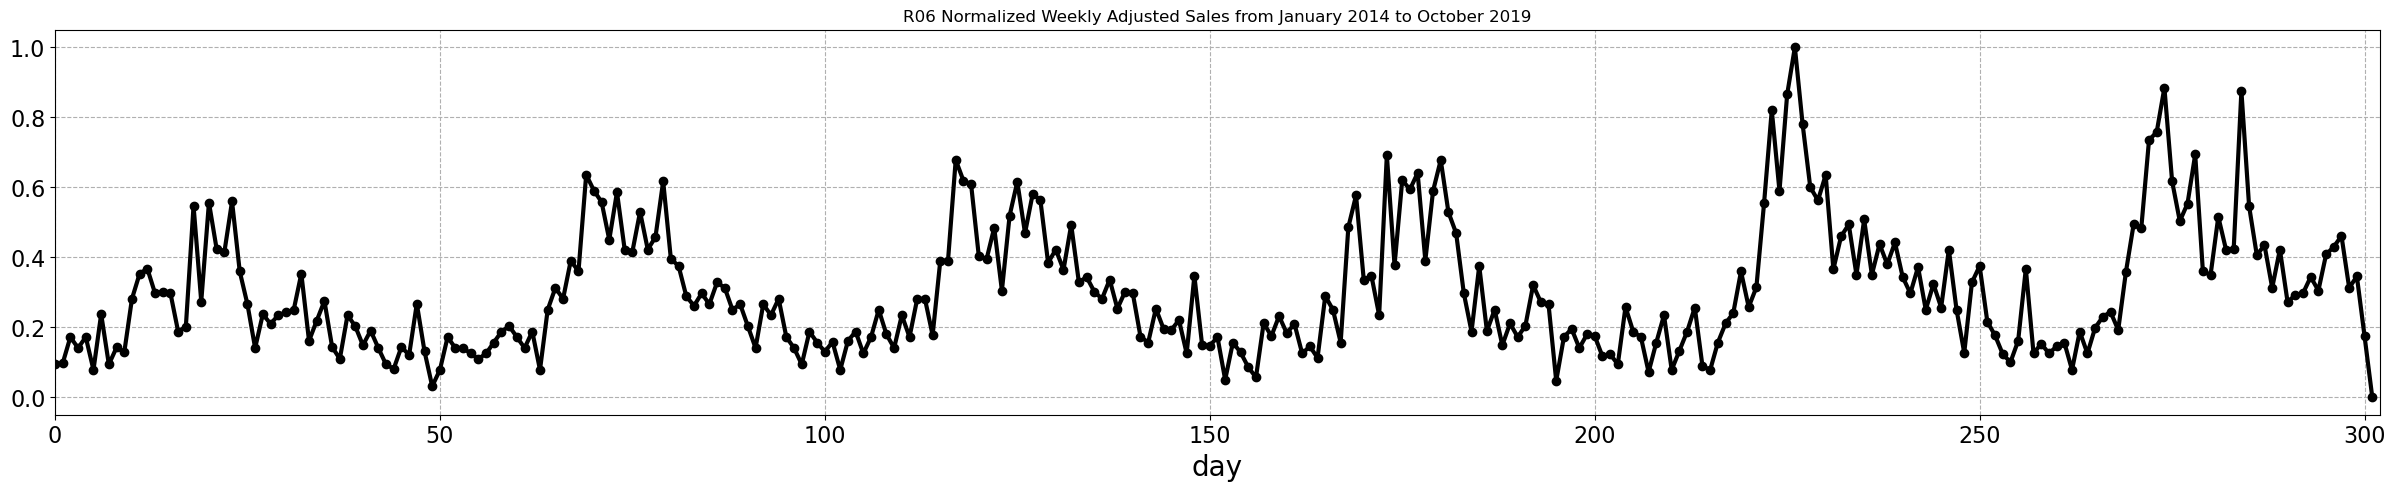

In [96]:
plt.figure(figsize=(30,5))
plt.plot(raw_data[:303],'ko-',linewidth=3)
plt.grid(linestyle='--')
plt.xlim(0,302)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('day',fontsize=20)
plt.title(med_name + " Normalized Weekly Adjusted Sales from January 2014 to October 2019")
plt.savefig(med_name + "-normalized.png")

##### Train/test data

In [97]:
dotrain = True
dotest = True
doanim = True

epochs = 400
batch_size = 32

dense_numunits = 16
conv1d_numunits = 32
simplernn_numunits = 16
lstm_numunits = 16

history_length = 262
forecast_length = 40

np.random.seed(237)
tensorflow.random.set_seed(237)

In [98]:
num_train_samples = int(0.8 * len(raw_data))
print("num_train_samples:", num_train_samples)

num_train_samples: 241


In [99]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [100]:
sequence_length = 52
trainX, trainY = create_dataset(raw_data[:num_train_samples], sequence_length)
testX, testY = create_dataset(raw_data[num_train_samples:], sequence_length)

In [101]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [102]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### DENSE

In [103]:
# model_dense = Sequential()
# model_dense.add(Flatten())
# model_dense.add(Dense(16, activation="relu"))
# model_dense.add(Dense(24))

In [104]:
# model_dense.compile(loss="mse", metrics=["mae"], optimizer="adam")

# history_dense = model_dense.fit(trainX, trainY, 
#                                 epochs=500, 
#                                 batch_size=32,
#                                 validation_data = (valX, valY) )

In [105]:
model_dense = Sequential()
model_dense.add(Flatten())
model_dense.add(Dense(16, activation="relu"))
model_dense.add(Dense(1))

model_dense.compile(loss="mse", metrics=["mae"], optimizer="adam")

# Train the dense model
dense_start = process_time()
history_dense = model_dense.fit(trainX, trainY, 
                              epochs=epochs, 
                              batch_size=batch_size,
                              validation_data = (testX, testY),
                              verbose=0)
dense_end = process_time()

# Measure fit time
dense_fit_time = dense_end - dense_start

model_dense.summary()

2024-03-26 18:39:53.026327: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-26 18:39:53.051040: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-26 18:39:53.054903: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 52)                0         
                                                                 
 dense (Dense)               (None, 16)                848       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 865 (3.38 KB)
Trainable params: 865 (3.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Conv1D

In [106]:
model_1Dconv = Sequential()
model_1Dconv.add(Conv1D(16, 1,input_shape=(1,sequence_length)))
model_1Dconv.add(Dense(1))


model_1Dconv.compile(loss='mse', metrics=["mae"], optimizer='adam')

# Train the Conv1D model
conv1d_start = process_time()
history_1Dconv = model_1Dconv.fit(trainX, trainY, 
                                  epochs=epochs, 
                                  batch_size=batch_size, 
                                  validation_data = (testX, testY),
                                  verbose=0)
conv1d_end = process_time()

# Measure fit time
conv1d_fit_time = conv1d_end - conv1d_start

model_1Dconv.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 16)             848       
                                                                 
 dense_2 (Dense)             (None, 1, 1)              17        
                                                                 
Total params: 865 (3.38 KB)
Trainable params: 865 (3.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Simple RNN

In [107]:
# model_simprnn = Sequential()
# model_simprnn.add(SimpleRNN(16, input_shape=(1,6)))             
# model_simprnn.add(Dense(24))
# model_simprnn.compile(loss="mse", metrics=["mae"], optimizer="adam")

# history_simprnn = model_simprnn.fit(trainX, trainY, 
#                                   epochs=500, 
#                                   batch_size=32, 
#                                   validation_data = (testX, testY) )

In [108]:
model_simprnn = Sequential()
model_simprnn.add(SimpleRNN(10, return_sequences=False,input_shape=(1,sequence_length)))             
model_simprnn.add(Dense(1))

model_simprnn.compile(loss="mse", metrics=["mae"], optimizer="adam")

# Train the simple RNN model
rnn_start = process_time()
history_simprnn = model_simprnn.fit(trainX, trainY, 
                                  epochs=epochs, 
                                  batch_size=batch_size, 
                                  validation_data = (testX, testY),
                                  verbose=0)
rnn_end = process_time()

# Measure fit time
rnn_fit_time = rnn_end - rnn_start

model_simprnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10)                630       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 641 (2.50 KB)
Trainable params: 641 (2.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### LSTM

In [109]:
# model_lstm = Sequential()
# model_lstm.add(LSTM(16, input_shape=(1, 6)))
# model_lstm.add(Dense(24))
# model.compile(loss='mse', metrics=["mae"])

# history = model.fit(trainX, trainY, 
#                  epochs=500, 
#                  batch_size=32, 
#                  validation_data = (valX, valY) )

In [110]:
model_lstm = Sequential()
model_lstm.add(LSTM(16, input_shape=(1, sequence_length)))
model_lstm.add(Dense(1))

model_lstm.compile(loss='mse', metrics=["mae"], optimizer='adam')

# Train the LSTM model
lstm_start = process_time()
history_lstm = model_lstm.fit(trainX, trainY, 
                         epochs=epochs, 
                         batch_size=batch_size, 
                         validation_data = (testX, testY),
                         verbose=0)
lstm_end = process_time()

# Measure fit time
lstm_fit_time = lstm_end - lstm_start

model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16)                4416      
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4433 (17.32 KB)
Trainable params: 4433 (17.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [111]:
# n_steps=5
# n_features = 1

# model_lstm_2 = Sequential()
# model_lstm_2.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(1, history_length)))
# model_lstm_2.add(LSTM(100, activation='relu'))
# model_lstm_2.add(Dense(1))
# model_lstm_2.compile(optimizer='adam', loss='mse')
# history_lstm_2 = model_lstm_2.fit(trainX, trainY, 
#                          epochs=epochs, 
#                          batch_size=batch_size, 
#                          validation_data = (valX, valY),
#                          verbose=0)
# model_lstm_2.summary()

### Stacked LSTM with 3 layers

In [112]:
model_lstm_2 = Sequential()
model_lstm_2.add(LSTM(16, activation='relu', return_sequences=True, input_shape=(1, sequence_length)))
model_lstm_2.add(LSTM(16, activation='relu', return_sequences=True))
model_lstm_2.add(LSTM(16, activation='relu'))
model_lstm_2.add(Dense(1))

model_lstm_2.compile(loss='mse', metrics=["mae"], optimizer='adam')

# Train the LSTM2 model
lstm2_start = process_time()
history_lstm_2 = model_lstm_2.fit(trainX, trainY, 
                         epochs=epochs, 
                         batch_size=batch_size, 
                         validation_data = (testX, testY),
                         verbose=0)
lstm2_end = process_time()

# Measure fit time
lstm2_fit_time = lstm2_end - lstm2_start

model_lstm_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 1, 16)             4416      
                                                                 
 lstm_2 (LSTM)               (None, 1, 16)             2112      
                                                                 
 lstm_3 (LSTM)               (None, 16)                2112      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 8657 (33.82 KB)
Trainable params: 8657 (33.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


##### PLOT

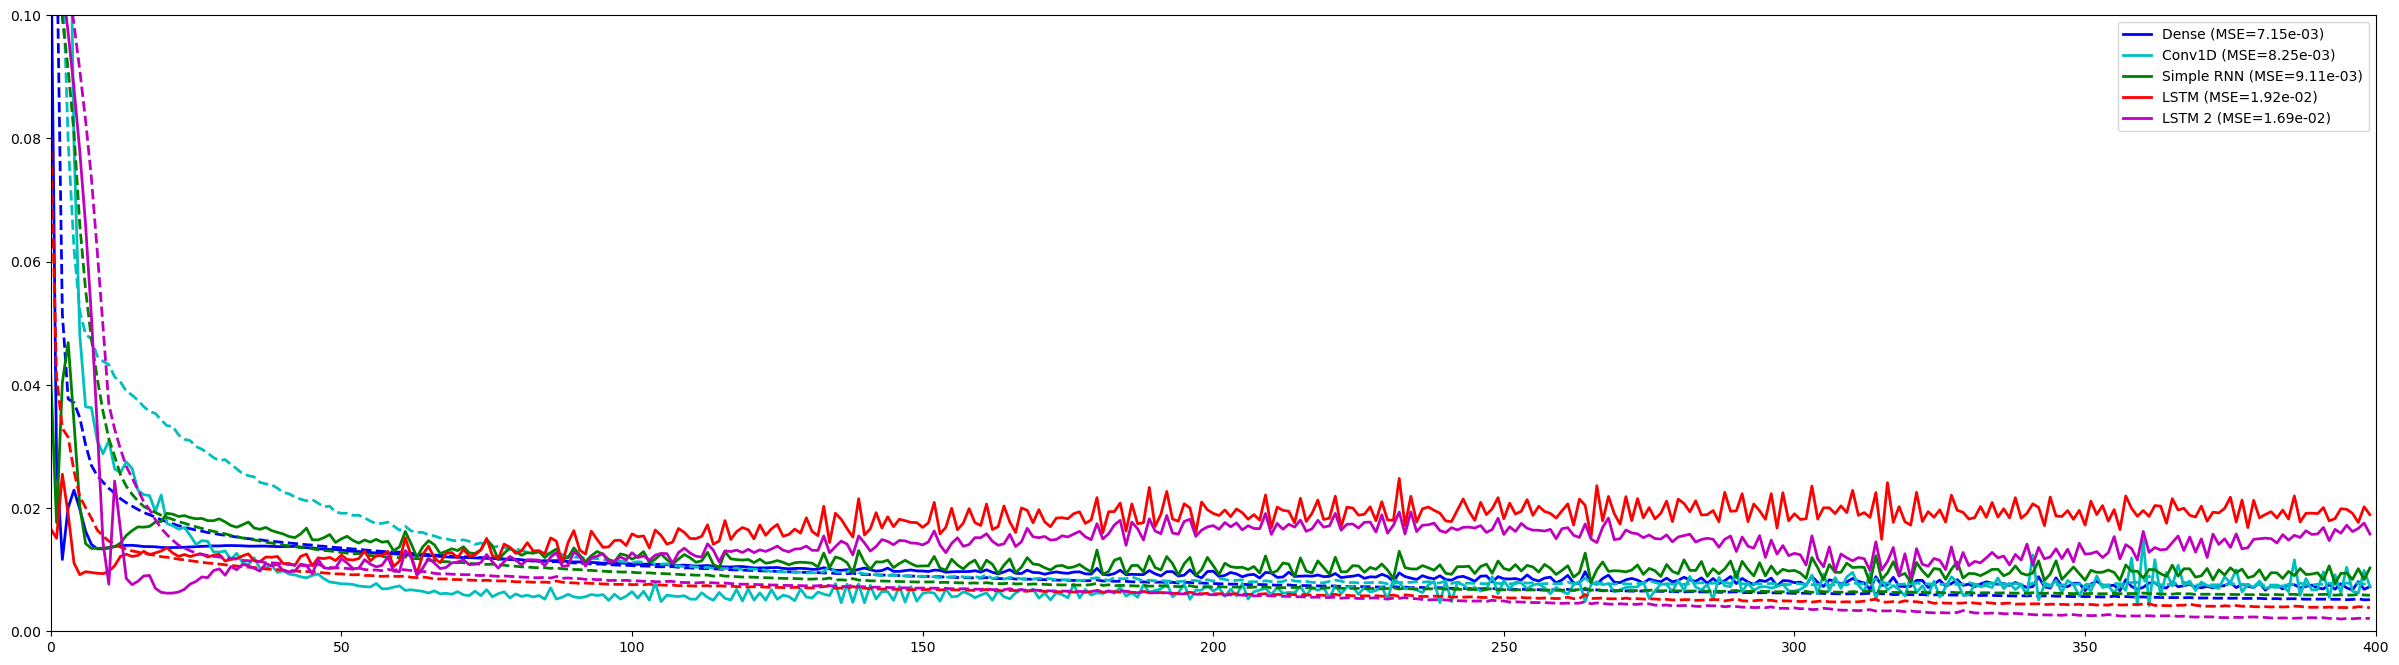

In [113]:
e = range(epochs)

mse_dense = np.mean(history_dense.history['val_loss'][-5:-1])
mse_conv1d = np.mean(history_1Dconv.history['val_loss'][-5:-1])
mse_simprnn = np.mean(history_simprnn.history['val_loss'][-5:-1])
mse_lstm = np.mean(history_lstm.history['val_loss'][-5:-1])
mse_lstm2 = np.mean(history_lstm_2.history['val_loss'][-5:-1])

plt.figure(figsize=(30,8))
plt.plot(e,history_dense.history['loss'], 'b--', linewidth=2)
plt.plot(e,history_dense.history['val_loss'], 'b-', linewidth=2,label='Dense (MSE={:.2e})'.format(mse_dense))
plt.plot(e,history_1Dconv.history['loss'], 'c--', linewidth=2)
plt.plot(e,history_1Dconv.history['val_loss'], 'c-', linewidth=2,label='Conv1D (MSE={:.2e})'.format(mse_conv1d))
plt.plot(e,history_simprnn.history['loss'], 'g--', linewidth=2)
plt.plot(e,history_simprnn.history['val_loss'], 'g-', linewidth=2,label='Simple RNN (MSE={:.2e})'.format(mse_simprnn))
plt.plot(e,history_lstm.history['loss'], 'r--', linewidth=2)
plt.plot(e,history_lstm.history['val_loss'], 'r-', linewidth=2, label='LSTM (MSE={:.2e})'.format(mse_lstm))
plt.plot(e,history_lstm_2.history['loss'], 'm--', linewidth=2)
plt.plot(e,history_lstm_2.history['val_loss'], 'm-', linewidth=2, label='LSTM 2 (MSE={:.2e})'.format(mse_lstm2))
plt.xlim(0,epochs)
plt.ylim(0,0.1)
plt.legend()
plt.savefig(med_name + "-" + str(epochs) + "-epochs-" + str(batch_size) + "-batch-size" + "-lstm.png")

The single-layer LSTM model converged very quickly and then jumped back up on it's MSE score.  Stacked LSTM also converged vey quickly.  Across multiple runs, there are instances where either LSTM, stacked LSTM, or Conv1D achieved the best performance.

In [114]:
# testX

In [115]:
# Generate predictions
predictions_dense = model_dense.predict(testX)
predictions_conv1D = model_1Dconv.predict(testX)
predictions_rnn = model_simprnn.predict(testX)
predictions_lstm = model_lstm.predict(testX)
predictions_lstm_2 = model_lstm_2.predict(testX)

print(predictions_dense.shape)
print(predictions_conv1D.shape)
print(predictions_rnn.shape)
print(predictions_lstm.shape)
print(predictions_lstm_2.shape)

1/1 [==============================] - 0s 247ms/step
(8, 1)
(8, 1, 1)
(8, 1)
(8, 1)
(8, 1)


In [116]:
predictions_conv1D = predictions_conv1D.reshape(8,1)

In [117]:
inv_predictions_dense = scaler.inverse_transform(predictions_dense)
inv_predictions_conv1D = scaler.inverse_transform(predictions_conv1D)
inv_predictions_rnn = scaler.inverse_transform(predictions_rnn)
inv_predictions_lstm = scaler.inverse_transform(predictions_lstm)
inv_predictions_lstm_2 = scaler.inverse_transform(predictions_lstm_2)

observation=scaler.inverse_transform(testY)

In [118]:
# def plot_rnn(df, med, params, preds):
#     num_plots = len(preds)
#     fig, axs = plt.subplots(num_plots, 1, squeeze=False, figsize=(30, 5*num_plots))
#     for i in range(0, num_plots):
#         axs[i,0].set_title(med + " SARIMA Model Forecast for (pdq) " + str(params[i][0]) + ", (PDQs) " + str(params[i][1]) + " and t " + str(params[i][2]))
#         axs[i,0].plot(df.index, preds[i], label = 'Forecast' )
#         axs[i,0].plot(df.index, df, alpha = 0.3, label = 'Data')
#         axs[i,0].grid()
#         axs[i,0].legend()
#         plt.savefig(med + " SARIMA Model Forecast for (pdq) " + str(params[i][0]) + ", (PDQs) " + str(params[i][1]) + " and t " + str(params[i][2]) + "-sarima-forecasts.png")
        
#     plt.show()

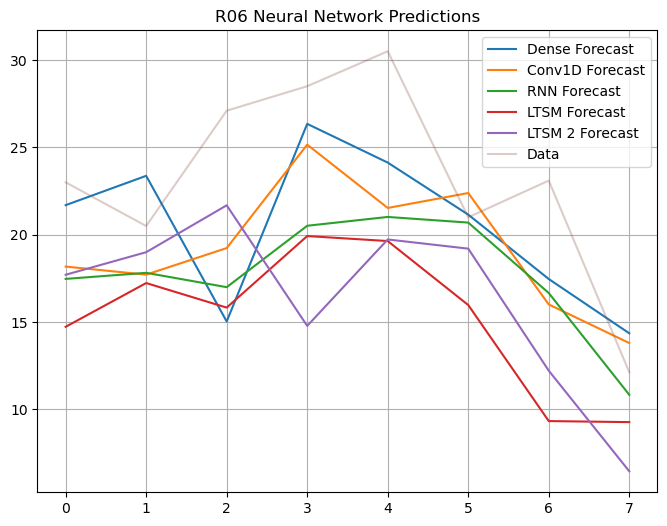

In [119]:
plt.figure(figsize=(8,6))
plt.plot(inv_predictions_dense, label = 'Dense Forecast' )
plt.plot(inv_predictions_conv1D, label = 'Conv1D Forecast' )
plt.plot(inv_predictions_rnn, label = 'RNN Forecast' )
plt.plot(inv_predictions_lstm, label = 'LTSM Forecast' )
plt.plot(inv_predictions_lstm_2, label = 'LTSM 2 Forecast' )
plt.plot(observation, alpha = 0.3, label = 'Data')
# plt.xticks(rotation = 60)
plt.title(med_name + ' Neural Network Predictions')
plt.savefig(med_name + "-nn-forecast.png")
plt.grid();
plt.legend();

In [120]:
rmse_dense = np.sqrt(mse_dense)
rmse_conv1d = np.sqrt(mse_conv1d)
rmse_simprnn = np.sqrt(mse_simprnn)
rmse_lstm = np.sqrt(mse_lstm)
rmse_lstm2 = np.sqrt(mse_lstm2)

print(rmse_dense)
print(rmse_conv1d)
print(rmse_simprnn)
print(rmse_lstm)
print(rmse_lstm2)

0.0845835115449164
0.09082864843587984
0.09543110545249121
0.13858442504159002
0.13006560649145343


In [121]:
rmse_dense_train = np.sqrt(np.mean(history_dense.history['loss'][-5:-1]))
rmse_conv1d_train = np.sqrt(np.mean(history_1Dconv.history['loss'][-5:-1]))
rmse_simprnn_train = np.sqrt(np.mean(history_simprnn.history['loss'][-5:-1]))
rmse_lstm_train = np.sqrt(np.mean(history_lstm.history['loss'][-5:-1]))
rmse_lstm2_train = np.sqrt(np.mean(history_lstm_2.history['loss'][-5:-1]))

print(rmse_dense_train)
print(rmse_conv1d_train)
print(rmse_simprnn_train)
print(rmse_lstm_train)
print(rmse_lstm2_train)

0.07188975442527333
0.08800240402263641
0.07686566411851671
0.0625105649616617
0.045638783006838476


In [122]:
mae_dense = np.mean(history_dense.history['val_mae'][-5:-1])
mae_conv1d = np.mean(history_1Dconv.history['val_mae'][-5:-1])
mae_simprnn = np.mean(history_simprnn.history['val_mae'][-5:-1])
mae_lstm = np.mean(history_lstm.history['val_mae'][-5:-1])
mae_lstm2 = np.mean(history_lstm_2.history['val_mae'][-5:-1])

print(mae_dense)
print(mae_conv1d)
print(mae_simprnn)
print(mae_lstm)
print(mae_lstm2)

0.0640159472823143
0.07679926790297031
0.07899660617113113
0.1257859542965889
0.11297499760985374


In [123]:
mae_dense_train = np.mean(history_dense.history['mae'][-5:-1])
mae_conv1d_train = np.mean(history_1Dconv.history['mae'][-5:-1])
mae_simprnn_train = np.mean(history_simprnn.history['mae'][-5:-1])
mae_lstm_train = np.mean(history_lstm.history['mae'][-5:-1])
mae_lstm2_train = np.mean(history_lstm_2.history['mae'][-5:-1])

print(mae_dense_train)
print(mae_conv1d_train)
print(mae_simprnn_train)
print(mae_lstm_train)
print(mae_lstm2_train)

0.056708636693656445
0.07037898153066635
0.061119841411709785
0.04792866576462984
0.035196549259126186


In [124]:
results_df.loc['Dense', ['train time']] = dense_fit_time
results_df.loc['Dense', ['train MAE']] = mae_dense_train
results_df.loc['Dense', ['test MAE']] = mae_dense
results_df.loc['Dense', ['train RMSE']] = rmse_dense_train
results_df.loc['Dense', ['test RMSE']] = rmse_dense

results_df.loc['RNN', ['train time']] = rnn_fit_time
results_df.loc['RNN', ['train MAE']] = mae_simprnn_train
results_df.loc['RNN', ['test MAE']] = mae_simprnn
results_df.loc['RNN', ['train RMSE']] = rmse_simprnn_train
results_df.loc['RNN', ['test RMSE']] = rmse_simprnn

results_df.loc['LSTM', ['train time']] = lstm_fit_time
results_df.loc['LSTM', ['train MAE']] = mae_lstm_train
results_df.loc['LSTM', ['test MAE']] = mae_lstm
results_df.loc['LSTM', ['train RMSE']] = rmse_lstm_train
results_df.loc['LSTM', ['test RMSE']] = rmse_lstm

results_df.loc['Conv1D', ['train time']] = conv1d_fit_time
results_df.loc['Conv1D', ['train MAE']] = mae_conv1d_train
results_df.loc['Conv1D', ['test MAE']] = mae_conv1d
results_df.loc['Conv1D', ['train RMSE']] = rmse_conv1d_train
results_df.loc['Conv1D', ['test RMSE']] = rmse_conv1d

results_df.loc['LSTM2', ['train time']] = lstm2_fit_time
results_df.loc['LSTM2', ['train MAE']] = mae_lstm2_train
results_df.loc['LSTM2', ['test MAE']] = mae_lstm2
results_df.loc['LSTM2', ['train RMSE']] = rmse_lstm2_train
results_df.loc['LSTM2', ['test RMSE']] = rmse_lstm2

In [125]:
results_df

train time  train MAE  test MAE  \
model                                                                
Baseline-Statsmodel Decomposition    0.002082   4.681426  6.141950   
Manual Decomposition                 1.124966   5.010217  8.116365   
ARMA                                 3.800801  10.305064  6.469667   
SARIMAX                              2.309046   5.427225  5.427225   
Dense                               13.460674   0.056709  0.064016   
RNN                                 15.644097   0.061120  0.078997   
LSTM                                16.935758   0.047929  0.125786   
Conv1D                              14.569031   0.070379  0.076799   
LSTM2                               33.991893   0.035197  0.112975   

                                   train RMSE  test RMSE  
model                                                     
Baseline-Statsmodel Decomposition    6.102017   7.830218  
Manual Decomposition                 6.513781  10.593812  
ARMA                                11.986801   8.329711  
SARIMAX                              7.146002   7.146002  
Dense                                0.071890   0.084584  
RNN                                  0.076866   0.095431  
LSTM                                 0.062511   0.138584  
Conv1D                               0.088002   0.090829  
LSTM2                                0.045639   0.130066

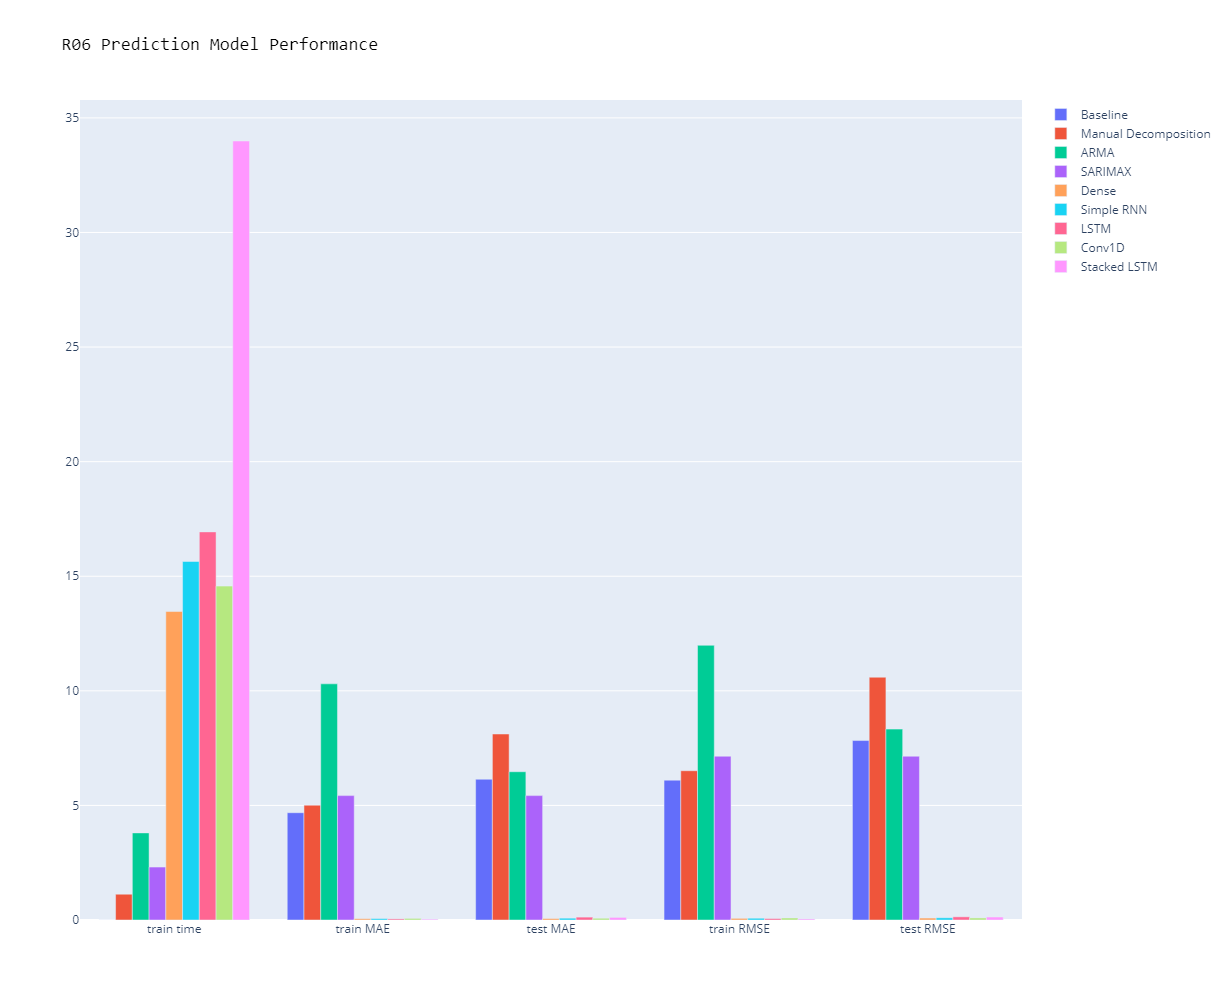

In [126]:
metrics = list(results_df.columns)

fig = go.Figure(data=[
    go.Bar(name='Baseline', x=metrics, y=results_df.loc['Baseline-Statsmodel Decomposition'].tolist()),
    go.Bar(name='Manual Decomposition', x=metrics, y=results_df.loc['Manual Decomposition'].tolist()),
    go.Bar(name='ARMA', x=metrics, y=results_df.loc['ARMA'].tolist()),
    go.Bar(name='SARIMAX', x=metrics, y=results_df.loc['SARIMAX'].tolist()),
    go.Bar(name='Dense', x=metrics, y=results_df.loc['Dense'].tolist()),
    go.Bar(name='Simple RNN', x=metrics, y=results_df.loc['RNN'].tolist()),
    go.Bar(name='LSTM', x=metrics, y=results_df.loc['LSTM'].tolist()),
    go.Bar(name='Conv1D', x=metrics, y=results_df.loc['Conv1D'].tolist()),
    go.Bar(name='Stacked LSTM', x=metrics, y=results_df.loc['LSTM2'].tolist())

])
# Change the bar mode
fig.update_layout(barmode='group')
fig.update_layout(
    height=1000,
    title=go.layout.Title(
        text= med_name + " Prediction Model Performance",
        font=dict(
            family="Trebuchet, monospace",
            size=18,
            color="black"
        )
    )
)
fig.show()
# fig.write_image(med_name + "-prediction-performance-plot.png", format="png")

#### Conclusion
There are a number of AI/ML regression models for time series predictions that perform well. For this project, I started by performing seasonal decomposition using the statsmodel library and manually. These activities improved my understanding of the data and process for building a seasonal decomposition.

To improve performance, I also explored using other regression models, namely ARMA, SARIMAX, and neural networks. For ARMA and SARIMAX, I created grid-search functions to iterate through input parameters to hone in on the best parameters.

For the neural networks, I tried a dense model, simple RNN, Conv1D, LSTM with one layer, and stacked LSTM with 3 hidden layers and one dense layer. The performance of the neural network predictions fluctuates between models. There are cases where the Conv1D model converges the fastest. At other times, LSTM and stacked LSTM perform the best.

The neural network models have the lowest RMSE, with LSTM, stacked LSTM, and Conv1D performing the best. However, neural networks require a high level of training. Also, setting up the train/test rolling window dataset was relatively more complex. The SARIMAX and the stats model seasonal decomposition are the easiest to use and interpret. These two models will be my first go-to when I must perform a time series analysis.

#### Next Steps
Additional work that will enhance my understanding of the models:
* **Troubleshoot animation for the neural network models.**  Unfortunately, I encountered errors while trying to do my animation. Getting it running will improve my understanding of the train/test window generation.
* **Get the XGBoost model to work.**  I tried to do XGBoost. However, I encountered errors with my train/test window setup.
* **Improve the grid search mechanism for the Sarimax model.**  I want to enhance my grid search mechanism to make it easier to find the best Sarimax model parameters.
* **Improve finetuning of my LSTM models.** I would like to better understand how to use the LSTM models effectively for time series analysis.

My exploration of time series models resulted in a valuable framework for evaluating them. With further enhancements, I can use this tool to perform real-world analysis and build a performant prediction model for production deployment. 

In [127]:
# if doanim:
    
#     tx0 = history_length-1 + np.arange(forecast_length+1)
#     tx1 = np.arange(30)
#     tx2 = np.arange(history_length)
#     ty = history_length + np.arange(forecast_length)
#     ind = 4

#     ypred_lstm = scaler.inverse_transform(model_lstm.predict(testX))
#     ypred_simprnn = scaler.inverse_transform(model_simprnn.predict(testX))
#     ypred_dense = scaler.inverse_transform(model_dense.predict(testX))
#     # raw_data_ = scaler.inverse_transform(raw_data)

#     fig = plt.figure(figsize=(12,6)) 
#     axis = plt.axes(xlim =(0, 30),ylim=(0,11662)) 

#     line0, = axis.plot([], [],':', color=[.1,.1,.1], lw = 1) 
#     line1, = axis.plot([], [],'ko-', lw = 3) 
#     line4, = axis.plot([], [],'bo-', lw = 2, label='Dense') 
#     line3, = axis.plot([], [],'go-', lw = 2, label='Simple RNN') 
#     line2, = axis.plot([], [],'co-', lw = 2, label='LSTM') 
#     plt.grid(linestyle='--')
#     plt.legend(fontsize=14,loc='lower left')
#     plt.xticks([])

#     def init(): 
#         line0.set_data([], [])
#         line1.set_data([], [])
#         line2.set_data([], [])
#         line3.set_data([], [])
#         line4.set_data([], [])
#         return line0, line1, line2, line3, line4

#     def animate(i):
#         x = raw_data[i+num_train_samples+history_length-1:i+num_train_samples+history_length+forecast_length]
#         line0.set_data(tx0,x)
#         line1.set_data(tx2,scaler.inverse_transform(testX[i]))
#         line2.set_data(ty,ypred_lstm[i])
#         line3.set_data(ty,ypred_simprnn[i])
#         line4.set_data(ty,ypred_dense[i])
#         return line1, line2, line3, line4

#     anim = FuncAnimation(fig, animate, init_func = init, 
#                          frames = 2000, interval = 20, blit = True)

#     anim.save('flow_pred.mp4', writer = 'ffmpeg', fps = 10)

In [128]:
# # Create the XGBoost model
# xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)

# # Train the LSTM2 model
# xgb_start = process_time()
# history_xgb = xgb_model.fit(trainX, trainY)
# xgb_end = process_time()

# # Measure fit time
# xgb_fit_time = xgb_end - xgb_start

In [129]:


# # Preprocess time series data
# xgb_data = df_r06_weekly['values'].diff().dropna()

# # Split data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(xgb_data.drop('values', axis=1), xgb_data['values'], test_size=0.2, shuffle=False)

# # Scale the input data using MinMaxScaler
# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Create the XGBoost model
# xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)

# # Train the model using the scaled training data
# xgb_model.fit(X_train_scaled, y_train)

# # Make predictions on the scaled test data
# y_pred = xgb_model.predict(X_test_scaled)

# # xgb_pred_error = y_test - y_pred
# # xgb_pred_MAEp = np.abs(xgb_pred_error).mean()
# # xgb_pred_RMSEp = np.sqrt( np.square(xgb_pred_error).mean())
# # xgb_pred_MAEp, xgb_pred_RMSEp


# # Predict on the training set
# pred_train = xgb_model.predict_proba(X_train)[:, 1]

# # Calculate the mean squared error on the training set
# mse_train = mean_squared_error(y_train, pred_train)
# best_arma_fit_time = end - start
# best_arma_rmse_test = np.sqrt(mean_squared_error(test, test_predictions))
# xgb_mae_test = mean_absolute_error(test, test_predictions)



##### Questions